In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import linregress
from scipy.signal import argrelmax, argrelmin
from sklearn.metrics import r2_score
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.cm as cm
import mpltools.annotation as annotation
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap
from matplotlib.ticker import AutoMinorLocator
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
from matplotlib.path import Path

In [2]:
plt.rcParams['font.family'] = 'Helvetica'

# DLS
## Determination of hydrodynamic radius

In this module, there are two systems to demonstrate the data analysis including (1) colloidal polystyrene dispersed in water and (2) colloidal silica nanoparticles (LUDOX TW-50) dispersed in water.

### Colloidal Polystyrene

In [3]:
base_path = '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement'

angle_info = {
    40: (3, 2),
    50: (4, 4),
    60: (5, 1),
    70: (6, 4),
    80: (7, 3),
    90: (8, 2),
    100: (9, 3),
    110: (10, 3),
    120: (11, 2),
    130: (12, 4),
    140: (13, 2),
}

for angle, (measurement, repetition) in angle_info.items():
    file_path = f'{base_path} {measurement}/Repetition{repetition}/Correlation Function.csv'
    globals()[f'PS100_{angle}'] = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

In [4]:
t_PS100_ms = []
g_PS100 = []
angle = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

for a in angle:
    t_PS100 = globals()[f"PS100_{a}"].iloc[28:, 0]
    globals()[f"t_PS100_{a}_ms"] = t_PS100 * 1000 
    t_PS100_ms.append(globals()[f"t_PS100_{a}_ms"])
    
    g_PS100_data = globals()[f"PS100_{a}"].iloc[28:, 1]
    globals()[f"g_PS100_{a}"] = g_PS100_data 
    g_PS100.append(globals()[f"g_PS100_{a}"])

$$
g(t) = exp(-\Gamma t)
$$

$$
q = \frac{4\pi n}{\lambda}sin(\frac{\theta}{2})
$$


In [5]:
angle_rad = [np.deg2rad(x) for x in angle]
n = 1.33
lambd = 660 #nm

q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in angle_rad]
q_3f = ['{:.3f}'.format(x) for x in q]

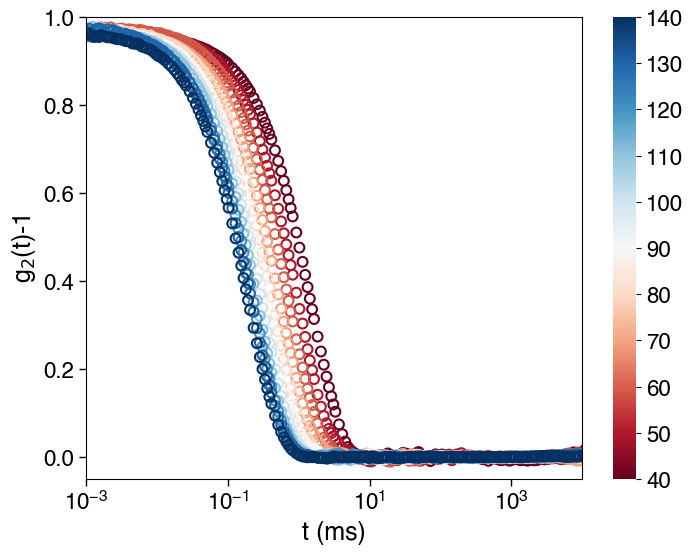

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('RdBu')
cmap_PS_DLS = ListedColormap(cmap(np.linspace(0, 1.1, 120)))


for idx, (x, y, label) in enumerate(zip(t_PS100_ms, g_PS100, angle)):
    c = cmap_PS_DLS(float(idx) / len(t_PS100_ms))
    scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=1.5, label=label)
    scatter1.set_facecolor('none') 

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.outline.set_visible(False)


ticks = np.linspace(0, 1, len(angle))
tick_labels = angle
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels, fontsize=16)


#ticks = np.linspace(0, 1, len(q_3f))
#tick_labels = q_3f
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(tick_labels)

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
#plt.legend(frameon=False, loc='lower left',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

In [7]:
def g(t, A, gamma):
    return A * np.exp(-(gamma * t))

p0 = [1, 1]
bounds = ([0, 0.001], [1, 100000])

A_fit_PS100 = []
gamma_fit_PS100 = []

for a in angle:
    t_data = globals()[f"t_PS100_{a}_ms"]
    g_data = globals()[f"g_PS100_{a}"]
    
    params, cov = curve_fit(g, t_data, g_data, p0, bounds=bounds)
    A_fit, gamma_fit = params
    
    globals()[f"A_fit_PS100_{a}"] = A_fit  
    globals()[f"gamma_fit_PS100_{a}"] = gamma_fit  
    
    A_fit_PS100.append(A_fit)
    gamma_fit_PS100.append(gamma_fit)

rt_fit_PS100 = [1 / gamma for gamma in gamma_fit_PS100]

table_Parameters_PS100 = {
    r'$\theta$ (°)': angle,
    'q (nm$^{-1}$)': q_3f,
    'A': A_fit_PS100,
    '$\Gamma$ (ms$^{-1}$)': gamma_fit_PS100,
    r'$\tau$ (ms)': rt_fit_PS100
}

table_Parameters_PS100_draw = pd.DataFrame(table_Parameters_PS100)

styled_table_Parameters_PS100_draw = table_Parameters_PS100_draw.style \
    .set_properties(**{'font-family': 'Georgia', 'text-align': 'center'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'Georgia')]}]) \
    .format({'A': '{:.3f}', '$\Gamma$ (ms$^{-1}$)': '{:.3f}', r'$\tau$ (ms)': '{:.3f}'}) \
    .hide(axis='index')

styled_table_Parameters_PS100_draw

$\theta$ (°),q (nm$^{-1}$),A,$\Gamma$ (ms$^{-1}$),$\tau$ (ms)
40,0.009,0.958,0.685,1.460
50,0.011,0.967,1.041,0.961
60,0.013,0.976,1.411,0.709
70,0.015,0.968,1.877,0.533
80,0.016,0.974,2.397,0.417
90,0.018,0.972,2.908,0.344
100,0.019,0.972,3.440,0.291
110,0.021,0.975,3.932,0.254
120,0.022,0.967,4.405,0.227
130,0.023,0.976,4.711,0.212


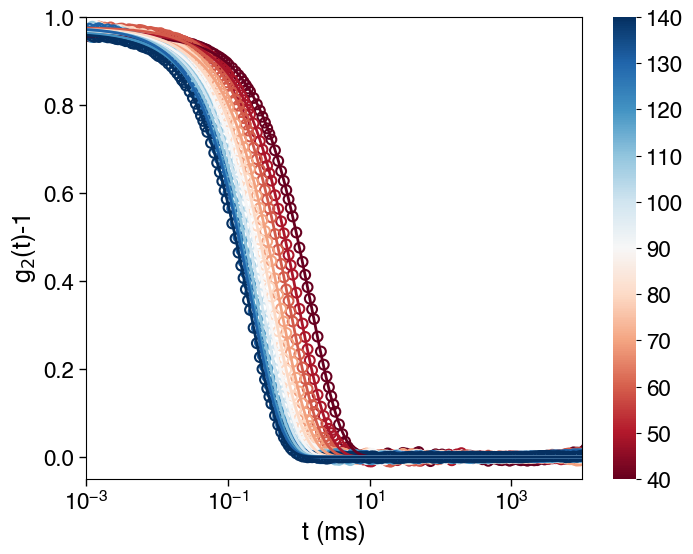

In [8]:
t_fit_PS100 = []
g_fit_PS100 = []

for a in angle:
    t_fit = np.logspace(-5, 4.5, 1000)

    g_fit = g(t_fit, globals()[f"A_fit_PS100_{a}"], globals()[f"gamma_fit_PS100_{a}"])
    
    t_fit_PS100.append(t_fit)
    g_fit_PS100.append(g_fit)


fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('RdBu')
cmap_PS_DLS = ListedColormap(cmap(np.linspace(0, 1.1, 120)))

for idx, (x, y, label) in enumerate(zip(t_PS100_ms, g_PS100, q_3f)):
    c = cmap_PS_DLS(float(idx) / len(t_PS100_ms))
    scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=1.5, label=label)
    scatter1.set_facecolor('none') 

for idx, (x, y, x1, y1, label) in enumerate(zip(t_PS100_ms, g_PS100, t_fit_PS100, g_fit_PS100, q_3f)):
    c = cmap_PS_DLS(float(idx) / len(t_PS100_ms))
    #scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
    #                      s=50, linewidths=1, label=label)
    plot1 = ax.plot(x1, y1, c=c, label=label, linewidth=2)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.outline.set_visible(False)


ticks = np.linspace(0, 1, len(angle))
tick_labels = angle
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels, fontsize=16)


#ticks = np.linspace(0, 1, len(q_3f))
#tick_labels = q_3f
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(tick_labels)

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
#plt.legend(frameon=False, loc='lower left',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time (q) fit Colloidal PS.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

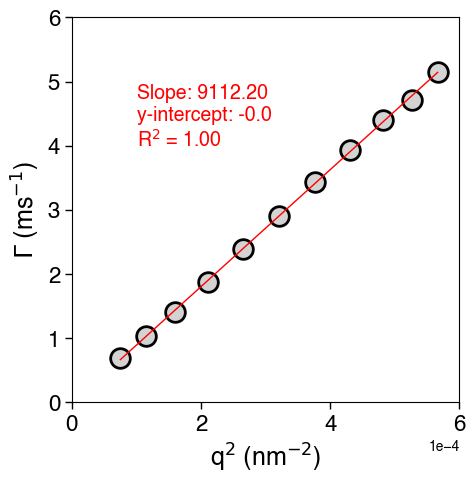

D = 9112.20 nm2/ms


In [9]:
PS100_q2_dls = [x**2 for x in q]

def linear_equation(x, m, c):
    return m * x + c


popt_PS_dls, pcov_PS_dls = curve_fit(linear_equation, PS100_q2_dls, gamma_fit_PS100)

slope_PS_dls, intercept_PS_dls = popt_PS_dls

x_PS_dls = np.linspace(min(PS100_q2_dls), max(PS100_q2_dls), 100)
y_PS_dls = slope_PS_dls * x_PS_dls + intercept_PS_dls

PS100_q2_dls = np.array(PS100_q2_dls)

y_pred_PS_dls = linear_equation(PS100_q2_dls, slope_PS_dls, intercept_PS_dls)

r_squared_PS_dls = r2_score(gamma_fit_PS100, y_pred_PS_dls[:len(gamma_fit_PS100)])

fig, ax = plt.subplots(figsize=(5, 5))
scatter1 = ax.scatter(PS100_q2_dls, gamma_fit_PS100, marker='o', facecolors='lightgray', edgecolors='k', 
                      s=200, linewidths=2)
ax.plot(x_PS_dls, y_PS_dls, color='red', linestyle='-', linewidth=1)

plt.xlabel('q$^2$ (nm$^{-2}$)', fontsize=18)
plt.ylabel('$\Gamma$ (ms$^{-1}$)', fontsize=18)  
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 6E-4)
plt.ylim(0, 6)

plt.text(0.1e-3, 4, f"Slope: {slope_PS_dls:.2f}\ny-intercept: {intercept_PS_dls:.1f}\nR$^2$ = {r_squared_PS_dls:.2f}", fontsize=14, c='red')

#plt.savefig("Gamma vs q^2 Colloidal PS.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

print(f'D = {slope_PS_dls:.2f} nm2/ms')

$$
D = 9112  \ nm^2/ms
$$

$$
R_h = \frac{kT}{6\pi\eta D}
$$

In [10]:
k_m = 1.380649*1e-23 #J/K = Pa.m^3/K
k_nm = k_m*1e+27 #Pa.nm^3/K
# 1 Joule = 1 Pa.m3
T_C = 24 #C
T_K = T_C + 273 #K
n = 0.9107*1e-3 #Pa.s
D_nm = slope_PS_dls*1e+3 #nm^2/ms =10^-18/10^-3
D_m = D_nm*1e-18 #m^2/s
Rh_dls_m = (k_m*T_K)/(6*np.pi*n*D_m) #(Pa*m^3/K*K)/(Pa*s*m^2/s)
Rh_dls_nm = (k_nm*T_K)/(6*np.pi*n*D_nm) #(Pa*nm^3/K*K)/(Pa*s*nm^2/s)
r = Rh_dls_m/Rh_dls_nm
print(f'Rh = {Rh_dls_m:.2e} m')
print(f'Rh = {Rh_dls_nm:.2f} nm')

Rh = 2.62e-08 m
Rh = 26.21 nm


$$
R_h \sim 26 nm
$$

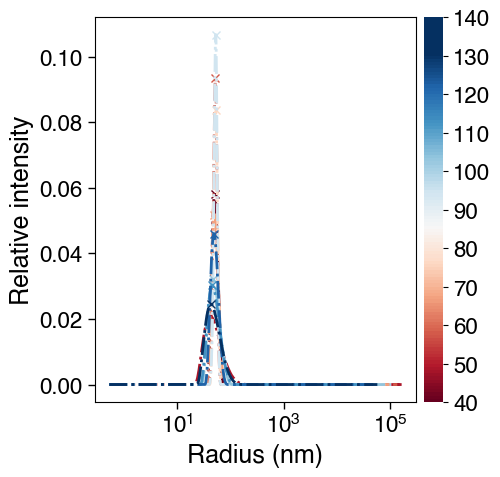

CORENN results:
At 40 deg, r = [50.8] nm
At 50 deg, r = [42.] nm
At 60 deg, r = [52.6] nm
At 70 deg, r = [50.6] nm
At 80 deg, r = [53.1] nm
At 90 deg, r = [44.7] nm
At 100 deg, r = [53.4] nm
At 110 deg, r = [47.5] nm
At 120 deg, r = [46.1] nm
At 130 deg, r = [49.3] nm
At 140 deg, r = [43.3] nm


In [11]:
from scipy.signal import find_peaks

angles = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

base_paths_PS = [
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 3/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 4/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 5/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 6/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 7/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 8/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 9/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 10/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 11/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 12/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS_DLS PS100 2D/Measurement 13/',
]

r_PS100 = []
rel_I_PS100 = []

for ang, base_path in zip(angles, base_paths_PS):
    for i in range(1, 4):
        file_path = f'{base_path}Repetition{i}/CORENN Size Results.csv'
        df = pd.read_csv(file_path, header=None, skiprows=(0,10))

        radius_var = f'r_PS100_{ang}_{i}'
        rel_I_var = f'rel_I_PS100_{ang}_{i}'
        cum_I_var = f'cum_I_PS100_{ang}_{i}'

        globals()[radius_var] = df.iloc[10:1220, 0].astype(float).values
        globals()[rel_I_var] = df.iloc[10:1220, 1].astype(float).values
        globals()[cum_I_var] = df.iloc[10:1220, 2].astype(float).values

        if i == 2:  
            r_PS100.append(globals()[radius_var])
            rel_I_PS100.append(globals()[rel_I_var])


fig, axs = plt.subplots(figsize=(5, 5))

cmap = plt.get_cmap('RdBu')
cmap_PS_DLS = ListedColormap(cmap(np.linspace(0, 1.1, 120)))

peak_positions = []

for idx, (x, y, label) in enumerate(zip(r_PS100, rel_I_PS100, angles)):
    c = cmap_PS_DLS(float(idx) / len(r_PS100))
    plot1 = plt.plot(x, y, c=c, linestyle='-.', linewidth=2, label=label)
    
    peaks, _ = find_peaks(y)
    
    #plt.fill_between(x, y, color=c, alpha=0.2)
    
    peak_positions.append(x[peaks])
    
    plt.plot(x[peaks], y[peaks], "x", c=c)
    
sm_VV = plt.cm.ScalarMappable(cmap=cmap_PS_DLS)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

plt.xscale("log")
plt.xlabel('Radius (nm)', fontsize=18)
plt.ylabel('Relative intensity', fontsize=18)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.show()

print("CORENN results:")
for angle, peaks in zip(angles, peak_positions):
    print(f"At {angle} deg, r = {peaks} nm")


## Comparison of different spherical nanoparticles

In [12]:
file_paths_PS_NPs = [
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/Measurement 1/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/Measurement 2/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/Measurement 3/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/Measurement 4/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/Measurement 5/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/Measurement 6/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/Measurement 7/Repetition3/Correlation Function.csv'
]

variable_names = ['PS_30', 'PS_45', 'PS_60', 'PS_75', 'PS_90', 'PS_105', 'PS_120']

data_frames = {}

for name, path in zip(variable_names, file_paths_PS_NPs):
    data_frames[name] = pd.read_csv(path, header=None, skiprows=[0, 1, 2])

t_PS_NPs_ms = []
g_PS_NPs = []
angle_PS_NPs = [30, 45, 60, 75, 90, 105, 120]

for a in angle_PS_NPs:
    t_PS_NPs = data_frames[f"PS_{a}"].iloc[28:, 0]
    t_PS_NPs_ms_val = t_PS_NPs * 1000 
    t_PS_NPs_ms.append(t_PS_NPs_ms_val)
    
    g_PS_NPs_data = data_frames[f"PS_{a}"].iloc[28:, 1]
    g_PS_NPs.append(g_PS_NPs_data)

file_paths_PS_f_NPs = [
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/Measurement 1/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/Measurement 2/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/Measurement 3/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/Measurement 4/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/Measurement 5/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/Measurement 6/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/Measurement 7/Repetition3/Correlation Function.csv'
]

variable_names_f = ['PS_f_30', 'PS_f_45', 'PS_f_60', 'PS_f_75', 'PS_f_90', 'PS_f_105', 'PS_f_120']

data_frames_f = {}

for name, path in zip(variable_names_f, file_paths_PS_f_NPs):
    data_frames_f[name] = pd.read_csv(path, header=None, skiprows=[0, 1, 2])

t_PS_f_NPs_ms = []
g_PS_f_NPs = []
angle_PS_f_NPs = [30, 45, 60, 75, 90, 105, 120]

for a in angle_PS_f_NPs:
    t_PS_f_NPs = data_frames_f[f"PS_f_{a}"].iloc[28:, 0]
    t_PS_f_NPs_ms_val = t_PS_f_NPs * 1000 
    t_PS_f_NPs_ms.append(t_PS_f_NPs_ms_val)
    
    g_PS_f_NPs_data = data_frames_f[f"PS_f_{a}"].iloc[28:, 1]
    g_PS_f_NPs.append(g_PS_f_NPs_data)

file_paths_PS_l_NPs = [
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/Measurement 1/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/Measurement 2/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/Measurement 3/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/Measurement 4/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/Measurement 5/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/Measurement 6/Repetition3/Correlation Function.csv',
    '/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/Measurement 7/Repetition3/Correlation Function.csv'
]

variable_names_l = ['PS_l_30', 'PS_l_45', 'PS_l_60', 'PS_l_75', 'PS_l_90', 'PS_l_105', 'PS_l_120']

data_frames_l = {}

for name, path in zip(variable_names_l, file_paths_PS_l_NPs):
    data_frames_l[name] = pd.read_csv(path, header=None, skiprows=[0, 1, 2])

t_PS_l_NPs_ms = []
g_PS_l_NPs = []
angle_PS_l_NPs = [30, 45, 60, 75, 90, 105, 120]

for a in angle_PS_l_NPs:
    t_PS_l_NPs = data_frames_l[f"PS_l_{a}"].iloc[28:, 0]
    t_PS_l_NPs_ms_val = t_PS_l_NPs * 1000 
    t_PS_l_NPs_ms.append(t_PS_l_NPs_ms_val)
    
    g_PS_l_NPs_data = data_frames_l[f"PS_l_{a}"].iloc[28:, 1]
    g_PS_l_NPs.append(g_PS_l_NPs_data)


In [13]:
t_PS_NPs_ms = []
g_PS_NPs = []
angle_PS_NPs = [30, 45, 60, 75, 90, 105, 120]

for a in angle_PS_NPs:
    t_PS_NPs = data_frames[f"PS_{a}"].iloc[28:, 0]
    t_PS_NPs_ms_val = t_PS_NPs * 1000
    t_PS_NPs_ms.append(t_PS_NPs_ms_val)

    g_PS_NPs_data = data_frames[f"PS_{a}"].iloc[28:, 1]
    g_PS_NPs.append(g_PS_NPs_data)

angle_PS_NPs_rad = [np.deg2rad(x) for x in angle_PS_NPs]
n = 1.33
lambd = 660  # nm

q_PS_NPs = [(4 * np.pi * n * np.sin(x / 2)) / (lambd) for x in angle_PS_NPs_rad]
q_PS_NPs_3f = ['{:.3f}'.format(x) for x in q_PS_NPs]

def g(t, A, gamma):
    return A * np.exp(-(gamma * t))

p0 = [1, 1]
bounds = ([0, 0.001], [1, 100000])

A_fit_PS_NPs = []
gamma_fit_PS_NPs = []

for t_data, g_data in zip(t_PS_NPs_ms, g_PS_NPs):
    params, cov = curve_fit(g, t_data, g_data, p0, bounds=bounds)
    A_fit, gamma_fit = params

    A_fit_PS_NPs.append(A_fit)
    gamma_fit_PS_NPs.append(gamma_fit)

rt_fit_PS_NPs = [1 / gamma for gamma in gamma_fit_PS_NPs]

table_Parameters_PS_NPs = {
    r'$\theta$ (°)': angle_PS_NPs,
    'q (nm$^{-1}$)': q_PS_NPs_3f,
    'A': A_fit_PS_NPs,
    '$\Gamma$ (ms$^{-1}$)': gamma_fit_PS_NPs,
    r'$\tau$ (ms)': rt_fit_PS_NPs
}

table_Parameters_PS_NPs_draw = pd.DataFrame(table_Parameters_PS_NPs)

styled_table_Parameters_PS_NPs_draw = table_Parameters_PS_NPs_draw.style \
    .set_properties(**{'font-family': 'Georgia', 'text-align': 'center'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'Georgia')]}]) \
    .format({'A': '{:.3f}', '$\Gamma$ (ms$^{-1}$)': '{:.3f}', r'$\tau$ (ms)': '{:.3f}'}) \
    .hide(axis='index')

styled_table_Parameters_PS_NPs_draw


$\theta$ (°),q (nm$^{-1}$),A,$\Gamma$ (ms$^{-1}$),$\tau$ (ms)
30,0.007,0.959,0.326,3.072
45,0.010,0.966,0.825,1.212
60,0.013,0.978,1.487,0.672
75,0.015,0.976,2.196,0.455
90,0.018,0.970,2.959,0.338
105,0.020,0.975,3.776,0.265
120,0.022,0.986,4.423,0.226


In [14]:
t_PS_f_NPs_ms = []
g_PS_f_NPs = []
angle_PS_f_NPs = [30, 45, 60, 75, 90, 105, 120]

for a in angle_PS_f_NPs:
    t_PS_f_NPs = data_frames_f[f"PS_f_{a}"].iloc[28:, 0]
    t_PS_f_NPs_ms_val = t_PS_f_NPs * 1000
    t_PS_f_NPs_ms.append(t_PS_f_NPs_ms_val)

    g_PS_f_NPs_data = data_frames_f[f"PS_f_{a}"].iloc[28:, 1]
    g_PS_f_NPs.append(g_PS_f_NPs_data)

angle_PS_f_NPs_rad = [np.deg2rad(x) for x in angle_PS_f_NPs]
n = 1.33
lambd = 660  # nm

q_PS_f_NPs = [(4 * np.pi * n * np.sin(x / 2)) / (lambd) for x in angle_PS_f_NPs_rad]
q_PS_f_NPs_3f = ['{:.3f}'.format(x) for x in q_PS_f_NPs]

def g(t, A, gamma):
    return A * np.exp(-(gamma * t))

p0 = [1, 1]
bounds = ([0, 0.001], [1, 100000])

A_fit_PS_f_NPs = []
gamma_fit_PS_f_NPs = []

for t_data, g_data in zip(t_PS_f_NPs_ms, g_PS_f_NPs):
    params, cov = curve_fit(g, t_data, g_data, p0, bounds=bounds)
    A_fit, gamma_fit = params

    A_fit_PS_f_NPs.append(A_fit)
    gamma_fit_PS_f_NPs.append(gamma_fit)

rt_fit_PS_f_NPs = [1 / gamma for gamma in gamma_fit_PS_f_NPs]


table_Parameters_PS_f_NPs = {
    r'$\theta$ (°)': angle_PS_f_NPs,
    'q (nm$^{-1}$)': q_PS_f_NPs_3f,
    'A': A_fit_PS_f_NPs,
    '$\Gamma$ (ms$^{-1}$)': gamma_fit_PS_f_NPs,
    r'$\tau$ (ms)': rt_fit_PS_f_NPs
}

table_Parameters_PS_f_NPs_draw = pd.DataFrame(table_Parameters_PS_f_NPs)

styled_table_Parameters_PS_f_NPs_draw = table_Parameters_PS_f_NPs_draw.style \
    .set_properties(**{'font-family': 'Georgia', 'text-align': 'center'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'Georgia')]}]) \
    .format({'A': '{:.3f}', '$\Gamma$ (ms$^{-1}$)': '{:.3f}', r'$\tau$ (ms)': '{:.3f}'}) \
    .hide(axis='index')

styled_table_Parameters_PS_f_NPs_draw

$\theta$ (°),q (nm$^{-1}$),A,$\Gamma$ (ms$^{-1}$),$\tau$ (ms)
30,0.007,0.967,0.296,3.380
45,0.010,0.978,0.663,1.508
60,0.013,0.966,1.196,0.836
75,0.015,0.945,1.819,0.550
90,0.018,0.961,2.420,0.413
105,0.020,0.964,3.032,0.330
120,0.022,0.962,3.535,0.283


In [15]:
t_PS_l_NPs_ms = []
g_PS_l_NPs = []
angle_PS_l_NPs = [30, 45, 60, 75, 90, 105, 120]

for a in angle_PS_l_NPs:
    t_PS_l_NPs = data_frames_l[f"PS_l_{a}"].iloc[28:, 0]
    t_PS_l_NPs_ms_val = t_PS_l_NPs * 1000
    t_PS_l_NPs_ms.append(t_PS_l_NPs_ms_val)

    g_PS_l_NPs_data = data_frames_l[f"PS_l_{a}"].iloc[28:, 1]
    g_PS_l_NPs.append(g_PS_l_NPs_data)

angle_PS_l_NPs_rad = [np.deg2rad(x) for x in angle_PS_l_NPs]
n = 1.33
lambd = 660  # nm

q_PS_l_NPs = [(4 * np.pi * n * np.sin(x / 2)) / (lambd) for x in angle_PS_l_NPs_rad]
q_PS_l_NPs_3f = ['{:.3f}'.format(x) for x in q_PS_l_NPs]

def g(t, A, gamma):
    return A * np.exp(-(gamma * t))

p0 = [1, 1]
bounds = ([0, 0.001], [1, 100000])

A_fit_PS_l_NPs = []
gamma_fit_PS_l_NPs = []

for t_data, g_data in zip(t_PS_l_NPs_ms, g_PS_l_NPs):
    params, cov = curve_fit(g, t_data, g_data, p0, bounds=bounds)
    A_fit, gamma_fit = params

    A_fit_PS_l_NPs.append(A_fit)
    gamma_fit_PS_l_NPs.append(gamma_fit)

rt_fit_PS_l_NPs = [1 / gamma for gamma in gamma_fit_PS_l_NPs]

table_Parameters_PS_l_NPs = {
    r'$\theta$ (°)': angle_PS_l_NPs,
    'q (nm$^{-1}$)': q_PS_l_NPs_3f,
    'A': A_fit_PS_l_NPs,
    '$\Gamma$ (ms$^{-1}$)': gamma_fit_PS_l_NPs,
    r'$\tau$ (ms)': rt_fit_PS_l_NPs
}

table_Parameters_PS_l_NPs_draw = pd.DataFrame(table_Parameters_PS_l_NPs)

styled_table_Parameters_PS_l_NPs_draw = table_Parameters_PS_l_NPs_draw.style \
    .set_properties(**{'font-family': 'Georgia', 'text-align': 'center'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'Georgia')]}]) \
    .format({'A': '{:.3f}', '$\Gamma$ (ms$^{-1}$)': '{:.3f}', r'$\tau$ (ms)': '{:.3f}'}) \
    .hide(axis='index')

styled_table_Parameters_PS_l_NPs_draw

$\theta$ (°),q (nm$^{-1}$),A,$\Gamma$ (ms$^{-1}$),$\tau$ (ms)
30,0.007,0.891,0.039,25.734
45,0.010,1.000,0.069,14.445
60,0.013,0.953,0.142,7.059
75,0.015,1.000,0.175,5.700
90,0.018,0.982,0.287,3.483
105,0.020,0.994,0.353,2.835
120,0.022,0.938,0.459,2.177


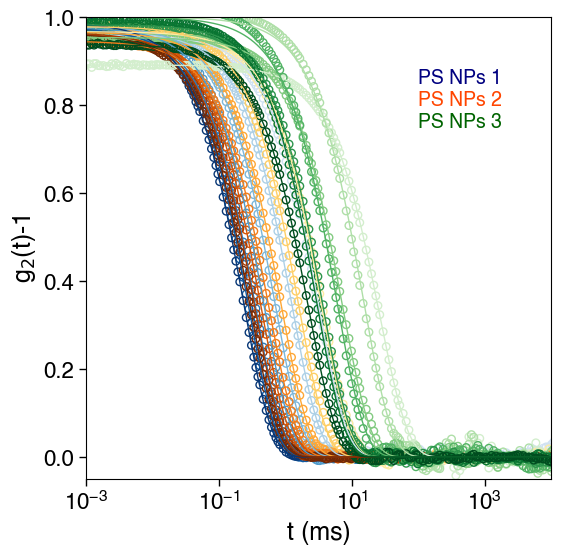

In [16]:
t_fit_PS_NPs = []
g_fit_PS_NPs = []

for A_fit, gamma_fit in zip(A_fit_PS_NPs, gamma_fit_PS_NPs):
    t_fit = np.logspace(-5, 4.5, 1000)
    g_fit = g(t_fit, A_fit, gamma_fit)

    t_fit_PS_NPs.append(t_fit)
    g_fit_PS_NPs.append(g_fit)
    
t_fit_PS_f_NPs = []
g_fit_PS_f_NPs = []

for A_fit, gamma_fit in zip(A_fit_PS_f_NPs, gamma_fit_PS_f_NPs):
    t_fit = np.logspace(-5, 4.5, 1000)
    g_fit = g(t_fit, A_fit, gamma_fit)

    t_fit_PS_f_NPs.append(t_fit)
    g_fit_PS_f_NPs.append(g_fit)
    
t_fit_PS_l_NPs = []
g_fit_PS_l_NPs = []

for A_fit, gamma_fit in zip(A_fit_PS_l_NPs, gamma_fit_PS_l_NPs):
    t_fit = np.logspace(-5, 4.5, 1000)
    g_fit = g(t_fit, A_fit, gamma_fit)

    t_fit_PS_l_NPs.append(t_fit)
    g_fit_PS_l_NPs.append(g_fit)

fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.get_cmap('Blues')
cmap_PS_NPs_DLS = ListedColormap(cmap(np.linspace(0.2, 1.1, 120)))

for idx, (x, y, label) in enumerate(zip(t_PS_NPs_ms, g_PS_NPs, angle_PS_NPs)):
    c = cmap_PS_NPs_DLS(float(idx) / len(t_PS_NPs_ms))
    scatter1 = ax.scatter(x, y, marker='o', facecolors=c, edgecolors=c,
                          s=30, linewidths=1, label=label)
    scatter1.set_facecolor('none')

for idx, (x, y, x1, y1, label) in enumerate(zip(t_PS_NPs_ms, g_PS_NPs, t_fit_PS_NPs, g_fit_PS_NPs, q_PS_NPs_3f)):
    c = cmap_PS_NPs_DLS(float(idx) / len(t_PS_NPs_ms))
    plot1 = ax.plot(x1, y1, c=c, label=label, linewidth=1)

cmap2 = plt.get_cmap('YlOrBr')
cmap_PS_f_NPs_DLS = ListedColormap(cmap2(np.linspace(0.2, 1.1, 120)))

for idx, (x, y, label) in enumerate(zip(t_PS_f_NPs_ms, g_PS_f_NPs, angle_PS_f_NPs)):
    c = cmap_PS_f_NPs_DLS(float(idx) / len(t_PS_f_NPs_ms))
    scatter1 = ax.scatter(x, y, marker='o', facecolors=c, edgecolors=c,
                          s=30, linewidths=1, label=label)
    scatter1.set_facecolor('none')

for idx, (x, y, x1, y1, label) in enumerate(zip(t_PS_f_NPs_ms, g_PS_f_NPs, t_fit_PS_f_NPs, g_fit_PS_f_NPs, q_PS_f_NPs_3f)):
    c = cmap_PS_f_NPs_DLS(float(idx) / len(t_PS_f_NPs_ms))
    plot1 = ax.plot(x1, y1, c=c, label=label, linewidth=1)
    
cmap3 = plt.get_cmap('Greens')
cmap_PS_l_NPs_DLS = ListedColormap(cmap3(np.linspace(0.2, 1.1, 120)))

for idx, (x, y, label) in enumerate(zip(t_PS_l_NPs_ms, g_PS_l_NPs, angle_PS_l_NPs)):
    c = cmap_PS_l_NPs_DLS(float(idx) / len(t_PS_l_NPs_ms))
    scatter1 = ax.scatter(x, y, marker='o', facecolors=c, edgecolors=c,
                          s=30, linewidths=1, label=label)
    scatter1.set_facecolor('none')

for idx, (x, y, x1, y1, label) in enumerate(zip(t_PS_l_NPs_ms, g_PS_l_NPs, t_fit_PS_l_NPs, g_fit_PS_l_NPs, q_PS_l_NPs_3f)):
    c = cmap_PS_l_NPs_DLS(float(idx) / len(t_PS_l_NPs_ms))
    plot1 = ax.plot(x1, y1, c=c, label=label, linewidth=1)

#sm = plt.cm.ScalarMappable(cmap=cmap_PS_NPs_DLS)
#sm.set_array([])
#cbar = plt.colorbar(sm)
#cbar.outline.set_visible(False)

#ticks = np.linspace(0, 1, len(angle_PS_NPs))
#tick_labels = angle_PS_NPs
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(tick_labels, fontsize=18)
plt.text(100, 0.85, "PS NPs 1", fontsize=14, c='navy')
plt.text(100, 0.8, "PS NPs 2", fontsize=14, c='orangered')
plt.text(100, 0.75, "PS NPs 3", fontsize=14, c='darkgreen')

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
plt.show()


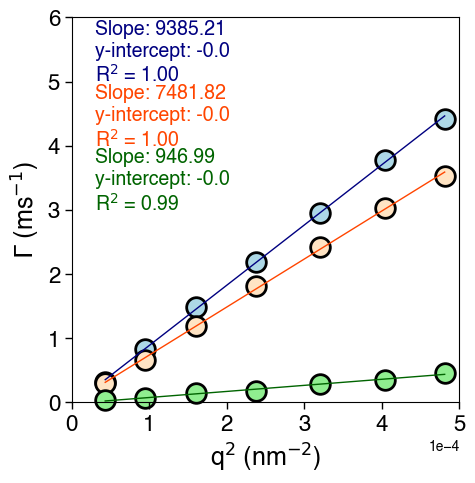

In [26]:
PS_NPs_q2_dls = [x**2 for x in q_PS_NPs]
PS_f_NPs_q2_dls = [x**2 for x in q_PS_f_NPs]
PS_l_NPs_q2_dls = [x**2 for x in q_PS_l_NPs]

def linear_equation(x, m, c):
    return m * x + c

popt_PS_NPs_dls, pcov_PS_NPs_dls = curve_fit(linear_equation, PS_NPs_q2_dls, gamma_fit_PS_NPs)

slope_PS_NPs_dls, intercept_PS_NPs_dls = popt_PS_NPs_dls

x_PS_NPs_dls = np.linspace(min(PS_NPs_q2_dls), max(PS_NPs_q2_dls), 100)
y_PS_NPs_dls = slope_PS_NPs_dls * x_PS_NPs_dls + intercept_PS_NPs_dls

PS_NPs_q2_dls = np.array(PS_NPs_q2_dls)

y_pred_PS_NPs_dls = linear_equation(PS_NPs_q2_dls, slope_PS_NPs_dls, intercept_PS_NPs_dls)

r_squared_PS_NPs_dls = r2_score(gamma_fit_PS_NPs, y_pred_PS_NPs_dls[:len(gamma_fit_PS_NPs)])


popt_PS_f_NPs_dls, pcov_PS_f_NPs_dls = curve_fit(linear_equation, PS_f_NPs_q2_dls, gamma_fit_PS_f_NPs)

slope_PS_f_NPs_dls, intercept_PS_f_NPs_dls = popt_PS_f_NPs_dls

x_PS_f_NPs_dls = np.linspace(min(PS_f_NPs_q2_dls), max(PS_f_NPs_q2_dls), 100)
y_PS_f_NPs_dls = slope_PS_f_NPs_dls * x_PS_f_NPs_dls + intercept_PS_f_NPs_dls

PS_f_NPs_q2_dls = np.array(PS_f_NPs_q2_dls)

y_pred_PS_f_NPs_dls = linear_equation(PS_f_NPs_q2_dls, slope_PS_f_NPs_dls, intercept_PS_f_NPs_dls)

r_squared_PS_f_NPs_dls = r2_score(gamma_fit_PS_f_NPs, y_pred_PS_f_NPs_dls[:len(gamma_fit_PS_f_NPs)])


popt_PS_l_NPs_dls, pcov_PS_l_NPs_dls = curve_fit(linear_equation, PS_l_NPs_q2_dls, gamma_fit_PS_l_NPs)

slope_PS_l_NPs_dls, intercept_PS_l_NPs_dls = popt_PS_l_NPs_dls

x_PS_l_NPs_dls = np.linspace(min(PS_l_NPs_q2_dls), max(PS_l_NPs_q2_dls), 100)
y_PS_l_NPs_dls = slope_PS_l_NPs_dls * x_PS_l_NPs_dls + intercept_PS_l_NPs_dls

PS_l_NPs_q2_dls = np.array(PS_l_NPs_q2_dls)

y_pred_PS_l_NPs_dls = linear_equation(PS_l_NPs_q2_dls, slope_PS_l_NPs_dls, intercept_PS_l_NPs_dls)

r_squared_PS_l_NPs_dls = r2_score(gamma_fit_PS_l_NPs, y_pred_PS_l_NPs_dls[:len(gamma_fit_PS_l_NPs)])


fig, ax = plt.subplots(figsize=(5, 5))
scatter1 = ax.scatter(PS_NPs_q2_dls, gamma_fit_PS_NPs, marker='o', facecolors='lightblue', edgecolors='k',
                      s=200, linewidths=2)
ax.plot(x_PS_NPs_dls, y_PS_NPs_dls, color='navy', linestyle='-', linewidth=1)

scatter2 = ax.scatter(PS_f_NPs_q2_dls, gamma_fit_PS_f_NPs, marker='o', facecolors='bisque', edgecolors='k',
                      s=200, linewidths=2)
ax.plot(x_PS_f_NPs_dls, y_PS_f_NPs_dls, color='orangered', linestyle='-', linewidth=1)

scatter3 = ax.scatter(PS_l_NPs_q2_dls, gamma_fit_PS_l_NPs, marker='o', facecolors='lightgreen', edgecolors='k',
                      s=200, linewidths=2, clip_on = False)
ax.plot(x_PS_l_NPs_dls, y_PS_l_NPs_dls, color='darkgreen', linestyle='-', linewidth=1)

plt.xlabel('q$^2$ (nm$^{-2}$)', fontsize=18)
plt.ylabel('$\Gamma$ (ms$^{-1}$)', fontsize=18)  
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 5E-4)
plt.ylim(0, 6)

plt.text(0.3e-4, 5, f"Slope: {slope_PS_NPs_dls:.2f}\ny-intercept: {intercept_PS_NPs_dls:.1f}\nR$^2$ = {r_squared_PS_NPs_dls:.2f}", fontsize=14, c='navy')

plt.text(0.3e-4, 4, f"Slope: {slope_PS_f_NPs_dls:.2f}\ny-intercept: {intercept_PS_f_NPs_dls:.1f}\nR$^2$ = {r_squared_PS_f_NPs_dls:.2f}", fontsize=14, c='orangered')

plt.text(0.3e-4, 3, f"Slope: {slope_PS_l_NPs_dls:.2f}\ny-intercept: {intercept_PS_l_NPs_dls:.1f}\nR$^2$ = {r_squared_PS_l_NPs_dls:.2f}", fontsize=14, c='darkgreen')

#plt.savefig("Gamma VS q^2 SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

In [27]:
k_m = 1.380649*1e-23 #J/K = Pa.m^3/K
k_nm = k_m*1e+27 #Pa.nm^3/K
# 1 Joule = 1 Pa.m3
T_C_PS_NPs = 23 #C
T_K_PS_NPs = T_C_PS_NPs + 273 #K
n_h2o = 1.0016*1e-3 #Pa.s

D_PS_NPs_nm = slope_PS_NPs_dls*1e+3 #nm^2/ms =10^-18/10^-3
D_PS_NPs_m = D_PS_NPs_nm*1e-18 #m^2/s

Rh_PS_NPs_dls_m = (k_m*T_K_PS_NPs)/(6*np.pi*n_h2o*D_PS_NPs_m) #(Pa*m^3/K*K)/(Pa*s*m^2/s)
Rh_PS_NPs_dls_nm = (k_nm*T_K_PS_NPs)/(6*np.pi*n_h2o*D_PS_NPs_nm) #(Pa*nm^3/K*K)/(Pa*s*nm^2/s)
r_PS_NPs = Rh_PS_NPs_dls_m/Rh_PS_NPs_dls_nm
print('PS1:')
print(f'Rh = {Rh_PS_NPs_dls_m:.2e} m')
print(f'Rh = {Rh_PS_NPs_dls_nm:.3f} nm\n')

D_PS_f_NPs_nm = slope_PS_f_NPs_dls*1e+3 #nm^2/ms =10^-18/10^-3
D_PS_f_NPs_m = D_PS_f_NPs_nm*1e-18 #m^2/s

Rh_PS_f_NPs_dls_m = (k_m*T_K_PS_NPs)/(6*np.pi*n_h2o*D_PS_f_NPs_m) #(Pa*m^3/K*K)/(Pa*s*m^2/s)
Rh_PS_f_NPs_dls_nm = (k_nm*T_K_PS_NPs)/(6*np.pi*n_h2o*D_PS_f_NPs_nm) #(Pa*nm^3/K*K)/(Pa*s*nm^2/s)
r_PS_f_NPs = Rh_PS_f_NPs_dls_m/Rh_PS_f_NPs_dls_nm
print('PS2:')
print(f'Rh = {Rh_PS_f_NPs_dls_m:.2e} m')
print(f'Rh = {Rh_PS_f_NPs_dls_nm:.3f} nm\n')

D_PS_l_NPs_nm = slope_PS_l_NPs_dls*1e+3 #nm^2/ms =10^-18/10^-3
D_PS_l_NPs_m = D_PS_l_NPs_nm*1e-18 #m^2/s

Rh_PS_l_NPs_dls_m = (k_m*T_K_PS_NPs)/(6*np.pi*n_h2o*D_PS_l_NPs_m) #(Pa*m^3/K*K)/(Pa*s*m^2/s)
Rh_PS_l_NPs_dls_nm = (k_nm*T_K_PS_NPs)/(6*np.pi*n_h2o*D_PS_l_NPs_nm) #(Pa*nm^3/K*K)/(Pa*s*nm^2/s)
r_PS_l_NPs = Rh_PS_l_NPs_dls_m/Rh_PS_l_NPs_dls_nm
print('PS3:')
print(f'Rh = {Rh_PS_l_NPs_dls_m:.2e} m')
print(f'Rh = {Rh_PS_l_NPs_dls_nm:.3f} nm\n')

PS1:
Rh = 2.31e-08 m
Rh = 23.064 nm

PS2:
Rh = 2.89e-08 m
Rh = 28.932 nm

PS3:
Rh = 2.29e-07 m
Rh = 228.578 nm



### Colloidal Silica: LUDOX TM50

In [28]:
base_path = '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement'

angle_info = {
    30: 1,
    45: 2,
    60: 3,
    75: 4,
    90: 5,
    105: 6,
    120: 7,
}

for angle, measurement in angle_info.items():
    file_path = f'{base_path} {measurement}/Repetition3/Correlation Function.csv'
    globals()[f'Si22_{angle}'] = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

t_Si22_ms = []
g_Si22 = []
angle_Si22 = [30, 45, 60, 75, 90, 105, 120]

for a in angle_Si22:
    t_Si22 = globals()[f"Si22_{a}"].iloc[28:, 0]
    globals()[f"t_Si22_{a}_ms"] = t_Si22 * 1000 
    t_Si22_ms.append(globals()[f"t_Si22_{a}_ms"])
    
    g_Si22_data = globals()[f"Si22_{a}"].iloc[28:, 1]
    globals()[f"g_Si22_{a}"] = g_Si22_data 
    g_Si22.append(globals()[f"g_Si22_{a}"])

$$
g(t) = exp(\Gamma \tau)
$$

$$
q = \frac{4\pi n}{\lambda}sin(\frac{\theta}{2})
$$

In [30]:
angle_Si22_rad = [np.deg2rad(x) for x in angle_Si22]
n = 1.33
lambd = 660 #nm

q_Si22 = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in angle_Si22_rad]
q_Si22_3f = ['{:.3f}'.format(x) for x in q_Si22]

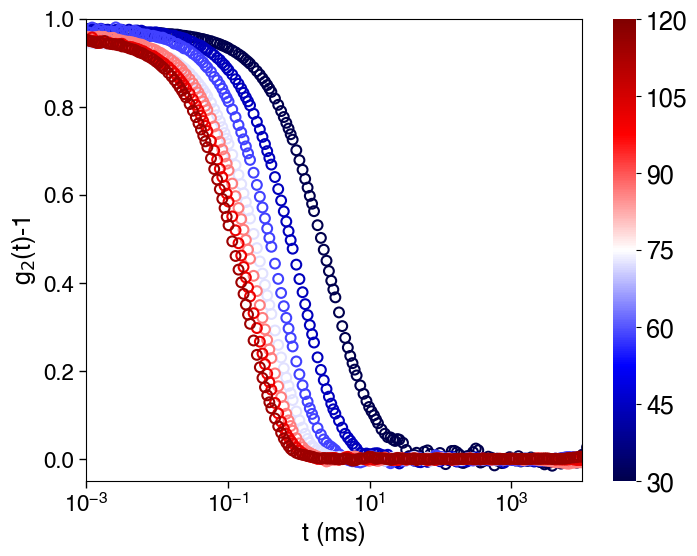

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('seismic')
cmap_Si_DLS = ListedColormap(cmap(np.linspace(0, 1.1, 120)))


for idx, (x, y, label) in enumerate(zip(t_Si22_ms, g_Si22, angle_Si22)):
    c = cmap_Si_DLS(float(idx) / len(t_Si22_ms))
    scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=1.5, label=label)
    scatter1.set_facecolor('none')
    
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.outline.set_visible(False)


ticks = np.linspace(0, 1, len(angle_Si22))
tick_labels = angle_Si22
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels, fontsize=18)

#ticks = np.linspace(0, 1, len(q_3f))
#tick_labels = q_3f
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(tick_labels)

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
#plt.legend(frameon=False, loc='lower left',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

In [32]:
def g(t, A, gamma):
    return A * np.exp(-(gamma * t))

p0 = [1, 1]
bounds = ([0, 0.001], [1, 100000])

A_fit_Si22 = []
gamma_fit_Si22 = []

for a in angle_Si22:
    t_data = globals()[f"t_Si22_{a}_ms"]
    g_data = globals()[f"g_Si22_{a}"]
    
    params, cov = curve_fit(g, t_data, g_data, p0, bounds=bounds)
    A_fit, gamma_fit = params
    
    globals()[f"A_fit_Si22_{a}"] = A_fit  
    globals()[f"gamma_fit_Si22_{a}"] = gamma_fit  
    
    A_fit_Si22.append(A_fit)
    gamma_fit_Si22.append(gamma_fit)

rt_fit_Si22 = [1 / gamma for gamma in gamma_fit_Si22]

table_Parameters_Si22 = {
    r'$\theta$ (°)': angle_Si22,
    'q (nm$^{-1}$)': q_Si22_3f,
    'A': A_fit_Si22,
    '$\Gamma$ (ms$^{-1}$)': gamma_fit_Si22,
    r'$\tau$ (ms)': rt_fit_Si22
}

table_Parameters_Si22_draw = pd.DataFrame(table_Parameters_Si22)

styled_table_Parameters_Si22_draw = table_Parameters_Si22_draw.style \
    .set_properties(**{'font-family': 'Georgia', 'text-align': 'center'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'Georgia')]}]) \
    .format({'A': '{:.3f}', '$\Gamma$ (ms$^{-1}$)': '{:.3f}', r'$\tau$ (ms)': '{:.3f}'}) \
    .hide(axis='index')

styled_table_Parameters_Si22_draw

$\theta$ (°),q (nm$^{-1}$),A,$\Gamma$ (ms$^{-1}$),$\tau$ (ms)
30,0.007,0.961,0.292,3.425
45,0.010,0.970,0.829,1.207
60,0.013,0.972,1.663,0.601
75,0.015,0.946,2.583,0.387
90,0.018,0.960,3.586,0.279
105,0.020,0.952,4.604,0.217
120,0.022,0.952,5.549,0.180


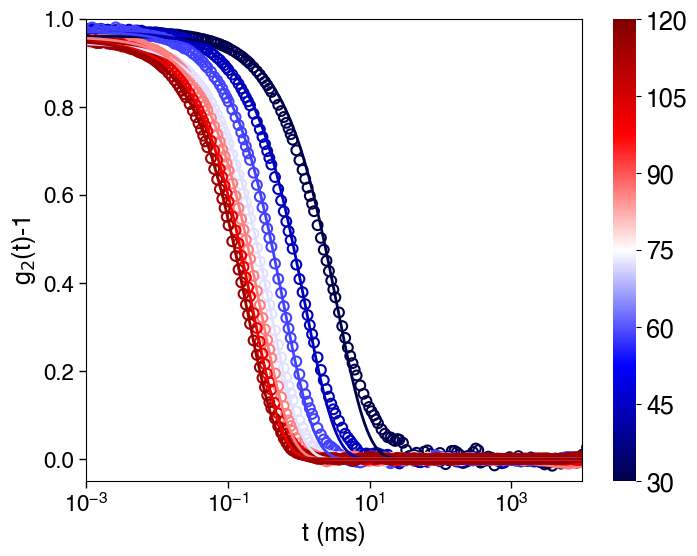

In [33]:
t_fit_Si22 = []
g_fit_Si22 = []

for a in angle_Si22:
    t_fit = np.logspace(-5, 4.5, 1000)

    g_fit = g(t_fit, globals()[f"A_fit_Si22_{a}"], globals()[f"gamma_fit_Si22_{a}"])
    
    t_fit_Si22.append(t_fit)
    g_fit_Si22.append(g_fit)


fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('seismic')
cmap_Si_DLS = ListedColormap(cmap(np.linspace(0, 1.1, 120)))


for idx, (x, y, label) in enumerate(zip(t_Si22_ms, g_Si22, angle_Si22)):
    c = cmap_Si_DLS(float(idx) / len(t_Si22_ms))
    scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=1.5, label=label)
    scatter1.set_facecolor('none')
    
for idx, (x, y, x1, y1, label) in enumerate(zip(t_Si22_ms, g_Si22, t_fit_Si22, g_fit_Si22, q_Si22_3f)):
    c = cmap_Si_DLS(float(idx) / len(t_fit_Si22))
    #scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
    #                      s=50, linewidths=1, label=label)
    plot1 = ax.plot(x1, y1, c=c, label=label, linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angle_Si22))
tick_labels = angle_Si22
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels, fontsize=18)

#ticks = np.linspace(0, 1, len(q_3f))
#tick_labels = q_3f
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(tick_labels)

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
#plt.legend(frameon=False, loc='lower left',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

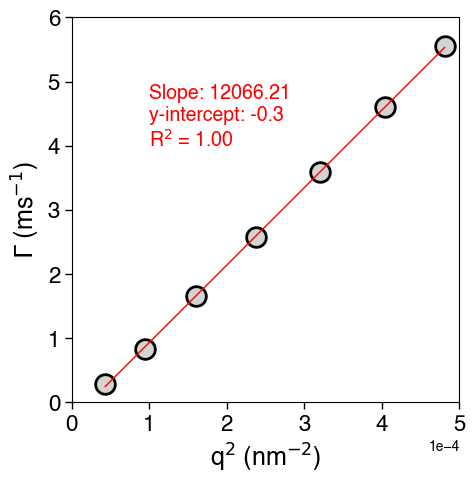

D = 12066.21 nm2/ms


In [34]:
Si22_q2_dls = [x**2 for x in q_Si22]

def linear_equation(x, m, c):
    return m * x + c


popt_Si_dls, pcov_Si_dls = curve_fit(linear_equation, Si22_q2_dls, gamma_fit_Si22)

slope_Si_dls, intercept_Si_dls = popt_Si_dls

x_Si_dls = np.linspace(min(Si22_q2_dls), max(Si22_q2_dls), 100)
y_Si_dls = slope_Si_dls * x_Si_dls + intercept_Si_dls

Si22_q2_dls = np.array(Si22_q2_dls)

y_pred_Si_dls = linear_equation(Si22_q2_dls, slope_Si_dls, intercept_Si_dls)

r_squared_Si_dls = r2_score(gamma_fit_Si22, y_pred_Si_dls[:len(gamma_fit_Si22)])

fig, ax = plt.subplots(figsize=(5, 5))
scatter1 = ax.scatter(Si22_q2_dls, gamma_fit_Si22, marker='o', facecolors='lightgray', edgecolors='k',
                      s=200, linewidths=2)
ax.plot(x_Si_dls, y_Si_dls, color='red', linestyle='-', linewidth=1)

plt.xlabel('q$^2$ (nm$^{-2}$)', fontsize=18)
plt.ylabel('$\Gamma$ (ms$^{-1}$)', fontsize=18)  
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 5E-4)
plt.ylim(0, 6)

plt.text(0.1e-3, 4, f"Slope: {slope_Si_dls:.2f}\ny-intercept: {intercept_Si_dls:.1f}\nR$^2$ = {r_squared_Si_dls:.2f}", fontsize=14, c='red')

#plt.savefig("Gamma VS q^2 SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

print(f'D = {slope_Si_dls:.2f} nm2/ms')

$$
D = 12180  \ nm^2/ms
$$

$$
R_h = \frac{kT}{6\pi\eta D}
$$

In [35]:
k_m = 1.380649*1e-23 #J/K = Pa.m^3/K
k_nm = k_m*1e+27 #Pa.nm^3/K
# 1 Joule = 1 Pa.m3
T_C_Si22 = 20 #C
T_K_Si22 = T_C_Si22 + 273 #K
n_Si22 = 1.0016*1e-3 #Pa.s
D_Si22_nm = slope_Si_dls*1e+3 #nm^2/ms =10^-18/10^-3
D_Si22_m = D_Si22_nm*1e-18 #m^2/s
Rh_Si22_dls_m = (k_m*T_K_Si22)/(6*np.pi*n_Si22*D_Si22_m) #(Pa*m^3/K*K)/(Pa*s*m^2/s)
Rh_Si22_dls_nm = (k_nm*T_K_Si22)/(6*np.pi*n_Si22*D_Si22_nm) #(Pa*nm^3/K*K)/(Pa*s*nm^2/s)
r_Si22 = Rh_Si22_dls_m/Rh_Si22_dls_nm
print(f'Rh = {Rh_Si22_dls_m:.2e} m')
print(f'Rh = {Rh_Si22_dls_nm:.3f} nm')


Rh = 1.78e-08 m
Rh = 17.758 nm


$$
R_h \sim 17.8 nm
$$

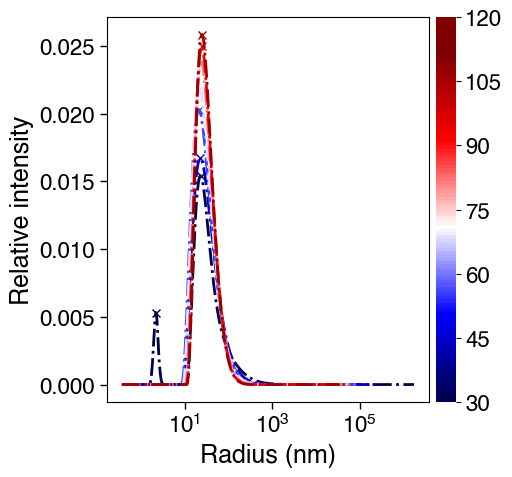

CORENN results:
At 40 deg, r = [ 2.22 23.2 ] nm
At 50 deg, r = [22.9] nm
At 60 deg, r = [21.2] nm
At 70 deg, r = [22.] nm
At 80 deg, r = [24.] nm
At 90 deg, r = [24.7] nm
At 100 deg, r = [25.] nm


In [36]:
angle_Si22 = [30, 45, 60, 75, 90, 105, 120]

base_paths_Si = [
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement 1/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement 2/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement 3/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement 4/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement 5/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement 6/',
    '/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/Measurement 7/'
]

r_Si = []
rel_I_Si = []

for ang, base_path in zip(angle_Si22, base_paths_Si):
    for i in range(1, 4):
        file_path = f'{base_path}Repetition{i}/CORENN Size Results.csv'
        df = pd.read_csv(file_path, header=None, skiprows=(0,10))

        radius_var = f'r_Si_{ang}_{i}'
        rel_I_var = f'rel_I_Si_{ang}_{i}'
        cum_I_var = f'cum_I_Si_{ang}_{i}'

        globals()[radius_var] = df.iloc[10:1220, 0].astype(float).values
        globals()[rel_I_var] = df.iloc[10:1220, 1].astype(float).values
        globals()[cum_I_var] = df.iloc[10:1220, 2].astype(float).values

        if i == 3:  
            r_Si.append(globals()[radius_var])
            rel_I_Si.append(globals()[rel_I_var])


fig, axs = plt.subplots(figsize=(5, 5))

cmap = plt.get_cmap('seismic')
cmap_Si_DLS = ListedColormap(cmap(np.linspace(0, 1.1, 120)))

peak_positions = []

for idx, (x, y, label) in enumerate(zip(r_Si, rel_I_Si, angles)):
    c = cmap_Si_DLS(float(idx) / len(r_Si))
    plot1 = plt.plot(x, y, c=c, linestyle='-.', linewidth=2, label=label)
    
    peaks, _ = find_peaks(y)
    
    #plt.fill_between(x, y, color=c, alpha=0.2)
    
    peak_positions.append(x[peaks])
    
    plt.plot(x[peaks], y[peaks], "x", c=c)
    
sm_VV = plt.cm.ScalarMappable(cmap=cmap_Si_DLS)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angle_Si22 ))
tick_labels = angle_Si22 
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

plt.xscale("log")
plt.xlabel('Radius (nm)', fontsize=18)
plt.ylabel('Relative intensity', fontsize=18)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.show()

print("CORENN results:")
for angle, peaks in zip(angles, peak_positions):
    print(f"At {angle} deg, r = {peaks} nm")


# DDLS
## Determination of shape and size dimensions of anisotropic NPs

In [53]:
## This method forces the same Gamma
def gVH(tau, A3, Gamma):
    return A3*np.exp(-Gamma * tau)

average_gammas_VH = []
std_gammas_VH = []
average_gammas_VV = []
std_gammas_VV = []
average_ys_VV = []
std_ys_VV = []
gamma_rs = []

angles = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
base_paths_VH = [
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 1/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 2/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 3/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 4/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 5/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 6/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 7/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 8/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 9/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 10/'
]
base_paths_VV = [
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 1/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 2/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 3/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 4/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 5/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 6/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 7/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 8/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 9/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 10/'
]

gamma_mixes = []

for ang, base_path_VH in zip(angles, base_paths_VH):
    fitted_params_VH = []
    for i in range(1, 4):
        file_path = f'{base_path_VH}Repetition{i}/Correlation Function.csv'
        df = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

        lagtime_var = f'lagtime_Aunrods_{ang}_{i}_VH'
        lagtime_ms_var = f'lagtime_Aunrods_{ang}_ms_{i}_VH'
        corrfx_var = f'corrfx_Aunrods_{ang}_{i}_VH'

        globals()[lagtime_var] = df.iloc[0:, 0]
        globals()[lagtime_ms_var] = globals()[lagtime_var] * 1000
        globals()[corrfx_var] = df.iloc[0:, 1]

        popt, _ = curve_fit(gVH, lagtime_ms, corrfx, p0=[1, 1], bounds=(0, np.inf))
        fitted_params_VH.append(popt)

    params_df_VH = pd.DataFrame(fitted_params_VH, columns=['A3', 'Gamma'])
    average_gamma_VH = params_df_VH['Gamma'].mean()
    std_gamma_VH = params_df_VH['Gamma'].std()

    average_gammas_VH.append(average_gamma_VH)
    std_gammas_VH.append(std_gamma_VH)

    gamma_mixes.append(average_gamma_VH)

    #print(f"Fitted VH parameters for angle {ang}:")
    #print(params_df_VH)
    #print(f"Average Gamma at {ang} degrees: {average_gamma_VH:.2f} 1/ms\n")

for ang, base_path_VV, gamma_mix in zip(angles, base_paths_VV, gamma_mixes):
    def gVV(tau, A1, A2, Gamma_t):
        return A1 * np.exp(-gamma_mix * tau) + A2 * np.exp(-Gamma_t * tau)
    
    fitted_params_VV = []
    for i in range(1, 4):
        file_path = f'{base_path_VV}Repetition{i}/Correlation Function.csv'
        df = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

        lagtime_var = f'lagtime_Aunrods_{ang}_{i}_VV'
        lagtime_ms_var = f'lagtime_Aunrods_{ang}_ms_{i}_VV'
        corrfx_var = f'corrfx_Aunrods_{ang}_{i}_VV'

        globals()[lagtime_var] = df.iloc[0:, 0]
        globals()[lagtime_ms_var] = globals()[lagtime_var] * 1000
        globals()[corrfx_var] = df.iloc[0:, 1]


        initial_guess = [0.5, 0.5, 1.0]
        bounds = [(0, 0, 0), (1, 1, np.inf)]

        popt, _ = curve_fit(gVV, lagtime_ms, corrfx, p0=initial_guess, bounds=bounds)
        
        fitted_params_VV.append(popt)
        

    params_df_VV = pd.DataFrame(fitted_params_VV, columns=['A1', 'A2', 'Gamma_t'])
    average_params_VV = params_df_VV.mean()
    std_params_VV = params_df_VV.std()

    average_gammas_VV.append(average_params_VV['Gamma_t'])
    std_gammas_VV.append(std_params_VV['Gamma_t'])

    gamma_r = gamma_mix - average_params_VV['Gamma_t']
    gamma_rs.append(gamma_r)

    #print(f"Fitted VV parameters for angle {ang}:")
    #print(params_df_VV)
    #print(f"Average Gamma_t at {ang} degrees: {average_params_VV['Gamma_t']:.2f} 1/ms")
    #print(f"Gamma_r at {ang} degrees: {gamma_r:.2f} 1/ms\n")

In [54]:
#This method allows different Gamma
def gVH(tau, A3, Gamma):
    return A3 * np.exp(-Gamma * tau)

def gVV(tau, A1, A2, Gamma, Gamma_t):
    return A1 * np.exp(- Gamma * tau) + A2 * np.exp(-Gamma_t * tau)

average_gammas_VH = []
std_gammas_VH = []
average_gammas_VV = []
average_gammas_VV_t = []
std_gammas_VV = []
std_gammas_VV_t = []
gamma_rs = []

angles = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
base_paths_VH = [
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 1/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 2/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 3/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 4/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 5/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 6/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 7/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 8/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 9/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VH/Measurement 10/'
]
base_paths_VV = [
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 1/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 2/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 3/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 4/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 5/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 6/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 7/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 8/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 9/',
    '/Users/ningravi/Desktop/Python/RawData/20240602/Au nanorods VV/Measurement 10/'
]

gamma_mixes = []

# Process VH data
for ang, base_path_VH in zip(angles, base_paths_VH):
    fitted_params_VH = []
    for i in range(1, 4):
        file_path = f'{base_path_VH}Repetition{i}/Correlation Function.csv'
        df = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])
        
        lagtime_var = f'lagtime_Aunrods_{ang}_{i}_VH'
        lagtime_ms_var = f'lagtime_Aunrods_{ang}_ms_{i}_VH'
        corrfx_var = f'corrfx_Aunrods_{ang}_{i}_VH'

        globals()[lagtime_var] = df.iloc[0:, 0]
        globals()[lagtime_ms_var] = globals()[lagtime_var] * 1000
        globals()[corrfx_var] = df.iloc[0:, 1]

        popt, _ = curve_fit(gVH, globals()[lagtime_ms_var], globals()[corrfx_var], p0=[1, 1], bounds=(0, np.inf))
        fitted_params_VH.append(popt)

    params_df_VH = pd.DataFrame(fitted_params_VH, columns=['A3', 'Gamma'])
    average_gamma_VH = params_df_VH['Gamma'].mean()
    std_gamma_VH = params_df_VH['Gamma'].std()

    average_gammas_VH.append(average_gamma_VH)
    std_gammas_VH.append(std_gamma_VH)

    gamma_mixes.append(average_gamma_VH)

    print(f"Fitted VH parameters for angle {ang}:")
    print(params_df_VH)
    print(f"Average Gamma at {ang} degrees: {average_gamma_VH:.2f} 1/ms\n")

# Process VV data
for ang, base_path_VV in zip(angles, base_paths_VV):
    fitted_params_VV = []
    for i in range(1, 4):
        file_path = f'{base_path_VV}Repetition{i}/Correlation Function.csv'
        df = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])
        
        lagtime_var = f'lagtime_Aunrods_{ang}_{i}_VV'
        lagtime_ms_var = f'lagtime_Aunrods_{ang}_ms_{i}_VV'
        corrfx_var = f'corrfx_Aunrods_{ang}_{i}_VV'

        globals()[lagtime_var] = df.iloc[0:, 0]
        globals()[lagtime_ms_var] = globals()[lagtime_var] * 1000
        globals()[corrfx_var] = df.iloc[0:, 1]

        initial_guess = [0.5, 0.5, 500, 1.0]
        bounds = [(0, 0, 0, 0), (1, 1, np.inf, np.inf)]

        popt, _ = curve_fit(gVV, globals()[lagtime_ms_var], globals()[corrfx_var], p0=initial_guess, bounds=bounds)
        fitted_params_VV.append(popt)

    params_df_VV = pd.DataFrame(fitted_params_VV, columns=['A1', 'A2', 'Gamma', 'Gamma_t'])
    average_params_VV = params_df_VV.mean()
    std_params_VV = params_df_VV.std()

    average_gammas_VV_t.append(average_params_VV['Gamma'])
    std_gammas_VV_t.append(std_params_VV['Gamma'])
    
    average_gammas_VV.append(average_params_VV['Gamma_t'])
    std_gammas_VV.append(std_params_VV['Gamma_t'])

    gamma_r = gamma_mixes[angles.index(ang)] - average_params_VV['Gamma_t']
    gamma_rs.append(gamma_r)

    print(f"Fitted VV parameters for angle {ang}:")
    print(params_df_VV)
    print(f"Average Gamma_t at {ang} degrees: {average_params_VV['Gamma_t']:.2f} 1/ms")
    print(f"Gamma_r at {ang} degrees: {gamma_r:.2f} 1/ms\n")


Fitted VH parameters for angle 30:
         A3       Gamma
0  0.973747  500.127684
1  0.976314  503.555207
2  0.973491  504.302036
Average Gamma at 30 degrees: 502.66 1/ms

Fitted VH parameters for angle 40:
         A3       Gamma
0  0.976021  504.508183
1  0.981814  504.978078
2  0.975931  505.852566
Average Gamma at 40 degrees: 505.11 1/ms

Fitted VH parameters for angle 50:
         A3       Gamma
0  0.978389  505.313665
1  0.984656  513.470768
2  0.983851  502.402436
Average Gamma at 50 degrees: 507.06 1/ms

Fitted VH parameters for angle 60:
         A3       Gamma
0  0.966068  535.985200
1  0.965003  538.660154
2  0.967074  541.897864
Average Gamma at 60 degrees: 538.85 1/ms

Fitted VH parameters for angle 70:
         A3       Gamma
0  0.966961  541.949110
1  0.971213  541.094198
2  0.967348  544.293102
Average Gamma at 70 degrees: 542.45 1/ms

Fitted VH parameters for angle 80:
         A3       Gamma
0  0.969901  544.873838
1  0.968177  547.507753
2  0.967369  546.413875
Aver

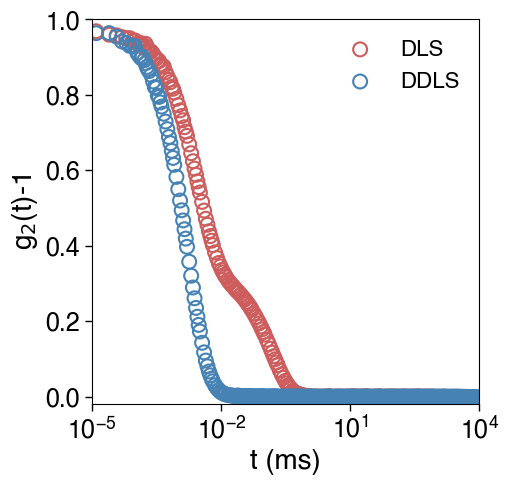

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))

c_DLS = 'maroon'
c_l_DLS = 'indianred'
c_DDLS = 'navy'
c_l_DDLS = 'steelblue'

scatter1 = ax.scatter(lagtime_Aunrods_80_ms_2_VV, corrfx_Aunrods_80_2_VV, marker='o', facecolors=c_l_DLS, edgecolors=c_l_DLS, 
                          s=100, linewidths=1.5, label= 'DLS')
scatter1.set_facecolor('none') 
scatter2 = ax.scatter(lagtime_Aunrods_80_ms_2_VH, corrfx_Aunrods_80_2_VH, marker='o', facecolors=c_l_DDLS, edgecolors=c_l_DDLS, 
                          s=100, linewidths=1.5, label= 'DDLS')
scatter2.set_facecolor('none')

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=20)
plt.ylabel('g$_2$(t)-1', fontsize=20)  
plt.legend(frameon=False, loc='best',fontsize=16)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
plt.xlim(1E-5, 1E4)
plt.ylim(-0.02, 1)
#plt.savefig("Correlation function VS lag time DLS vs DDLS at 80deg.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

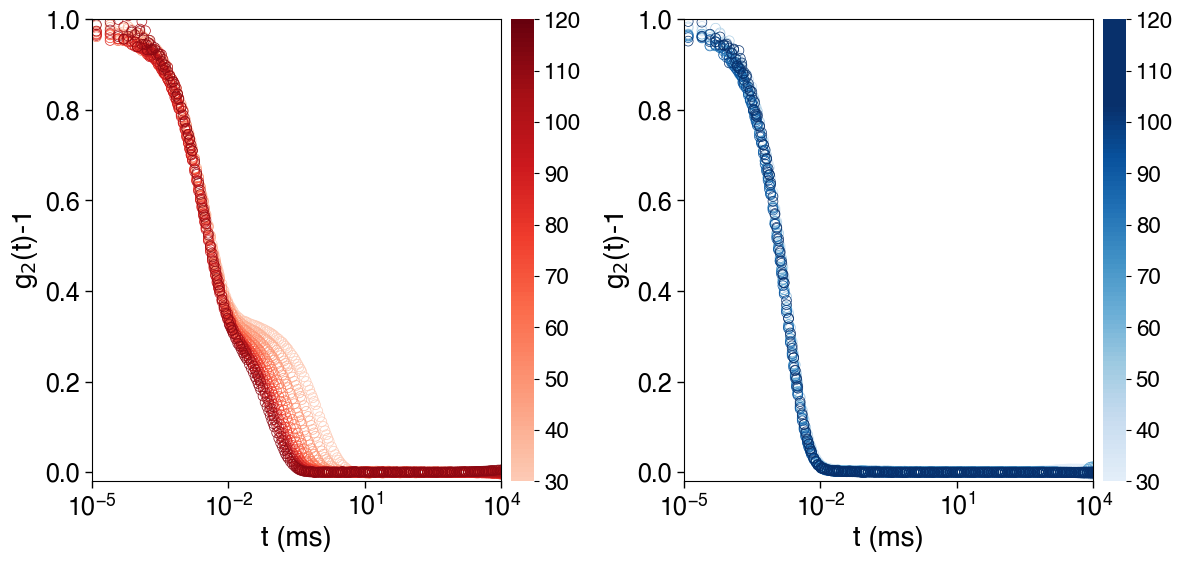

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

lagtime_VV = [lagtime_Aunrods_30_ms_2_VV, lagtime_Aunrods_40_ms_2_VV, lagtime_Aunrods_50_ms_2_VV, 
              lagtime_Aunrods_60_ms_2_VV, lagtime_Aunrods_70_ms_2_VV, lagtime_Aunrods_80_ms_2_VV, 
              lagtime_Aunrods_90_ms_2_VV, lagtime_Aunrods_100_ms_2_VV, lagtime_Aunrods_110_ms_2_VV, lagtime_Aunrods_120_ms_2_VV]
corrfx_VV = [corrfx_Aunrods_30_2_VV, corrfx_Aunrods_40_2_VV, corrfx_Aunrods_50_2_VV, 
             corrfx_Aunrods_60_2_VV, corrfx_Aunrods_70_2_VV, corrfx_Aunrods_80_2_VV, 
             corrfx_Aunrods_90_2_VV, corrfx_Aunrods_100_2_VV, corrfx_Aunrods_110_2_VV, corrfx_Aunrods_120_2_VV]


lagtime_VH = [lagtime_Aunrods_30_ms_2_VH, lagtime_Aunrods_40_ms_2_VH, lagtime_Aunrods_50_ms_2_VH, 
              lagtime_Aunrods_60_ms_2_VH, lagtime_Aunrods_70_ms_2_VH, lagtime_Aunrods_80_ms_2_VH, 
              lagtime_Aunrods_90_ms_2_VH, lagtime_Aunrods_100_ms_2_VH, lagtime_Aunrods_110_ms_2_VH, lagtime_Aunrods_120_ms_2_VH]
corrfx_VH = [corrfx_Aunrods_30_2_VH, corrfx_Aunrods_40_2_VH, corrfx_Aunrods_50_2_VH, 
             corrfx_Aunrods_60_2_VH, corrfx_Aunrods_70_2_VH, corrfx_Aunrods_80_2_VH, 
             corrfx_Aunrods_90_2_VH, corrfx_Aunrods_100_2_VH, corrfx_Aunrods_110_2_VH, corrfx_Aunrods_120_2_VH]


cmap_VV_0 = plt.get_cmap('Reds')
cmap_VV = ListedColormap(cmap_VV_0(np.linspace(0.2, 1.0, 100)))
cmap_VH_0 = plt.get_cmap('Blues')
cmap_VH = ListedColormap(cmap_VH_0(np.linspace(0.1, 1.2, 100)))

ax1 = axs[0]
for idx, (x, y, label) in enumerate(zip(lagtime_VV, corrfx_VV, angles)):
    c = cmap_VV(float(idx) / len(lagtime_VV))
    scatter1 = ax1.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')
    
sm_VV = plt.cm.ScalarMappable(cmap=cmap_VV)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, ax=ax1, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

ax2 = axs[1]
for idx, (x, y, label) in enumerate(zip(lagtime_VH, corrfx_VH, angles)):
    c = cmap_VH(float(idx) / len(lagtime_VH))
    scatter1 = ax2.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')

sm_VH = plt.cm.ScalarMappable(cmap=cmap_VH)
sm_VH.set_array([])
cbar_VH = plt.colorbar(sm_VH, ax=ax2, orientation='vertical', pad=0.02)
cbar_VH.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VH.set_ticks(ticks)
cbar_VH.set_ticklabels(tick_labels, fontsize=16)

for ax in axs.flat:
    ax.set_xscale("log")
    ax.set_xlabel('t (ms)', fontsize=20)
    ax.set_ylabel('g$_2$(t)-1', fontsize=20)
    #ax.legend(frameon=False, loc='best', fontsize=16)
    ax.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.set_xlim(1E-5, 1E4)
    ax.set_ylim(-0.02, 1)
#plt.savefig("Correlation function VS lag time DLS vs DDLS.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

$$
q = \frac{4\pi n}{\lambda}sin(\frac{\theta}{2})
$$

For anisotropic nanoparticles:

$$
G_{VV} (\tau) = A_1 exp(-(\Gamma_t+\Gamma_r))+A_2 exp(-\Gamma_t \tau) + B
$$

$$
G_{VH} (\tau) = A_3 exp(-(\Gamma_t+\Gamma_r)\tau) + B'
$$

$$
\Gamma_t = D_t q^2
$$

$$
\Gamma_r = 6D_r
$$

$$
\Gamma = \Gamma_t+\Gamma_r = q^2D_T+6D_R
$$
\
$D_T$ = Translational diffusion coefficient 
\
$D_R$ = Rotational diffusion coefficient 

In [57]:
angle_rad = [np.deg2rad(x) for x in angles]
n = 1.33
lambd = 660 #nm

q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in angle_rad]
q2 = [x**2 for x in q] #nm^-2
q2_2 = ['{:.6f}'.format(x) for x in q2]

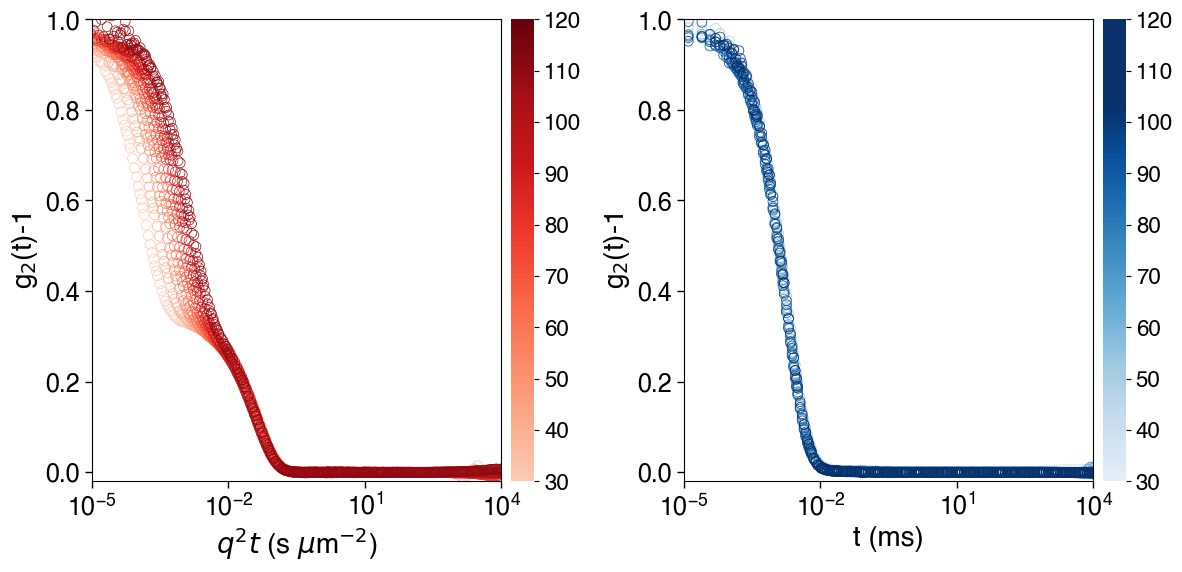

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

cmap_VV_0 = plt.get_cmap('Reds')
cmap_VV = ListedColormap(cmap_VV_0(np.linspace(0.2, 1.0, 100)))
cmap_VH_0 = plt.get_cmap('Blues')
cmap_VH = ListedColormap(cmap_VH_0(np.linspace(0.1, 1.2, 100)))

ax1 = axs[0]
for idx, (x, y, label, q2_val) in enumerate(zip(lagtime_VV, corrfx_VV, angles, q2)):
    x_new = x * q2_val * 1000  # Adjust x values
    c = cmap_VV(float(idx) / len(lagtime_VV))
    scatter1 = ax1.scatter(x_new, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')

sm_VV = plt.cm.ScalarMappable(cmap=cmap_VV)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, ax=ax1, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

ax2 = axs[1]
for idx, (x, y, label) in enumerate(zip(lagtime_VH, corrfx_VH, angles)):
    c = cmap_VH(float(idx) / len(lagtime_VH))
    scatter1 = ax2.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')

sm_VH = plt.cm.ScalarMappable(cmap=cmap_VH)
sm_VH.set_array([])
cbar_VH = plt.colorbar(sm_VH, ax=ax2, orientation='vertical', pad=0.02)
cbar_VH.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VH.set_ticks(ticks)
cbar_VH.set_ticklabels(tick_labels, fontsize=16)

ax1.set_xlabel(r'$q^2 t$ (s $\mu$m$^{-2}$)', fontsize=20)
ax2.set_xlabel('t (ms)', fontsize=20)
ax2.set_xlim(1E-5, 1E4)
ax1.set_xlim(1E-5, 1E4)
for ax in axs.flat:
    ax.set_xscale("log")
    ax.set_ylabel('g$_2$(t)-1', fontsize=20)
    ax.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.set_ylim(-0.02, 1)
# plt.savefig("Correlation function VS lag time DLS vs DDLS.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()


In [71]:
for ang, base_path in zip(angles, base_paths_VV):
    for i in range(1, 4):
        file_path = f'{base_path}Repetition{i}/CORENN Size Results.csv'
        df = pd.read_csv(file_path, header=None, skiprows=(0,9))

        radius_var = f'r_Aunrods_{ang}_{i}_VV'
        rel_I_var = f'rel_I_Aunrods_{ang}_{i}_VV'
        cum_I_var = f'cum_I_Aunrods_{ang}_{i}_VV'

        globals()[radius_var] = df.iloc[10:1645, 0]
        globals()[rel_I_var] = df.iloc[10:1645, 1]
        globals()[cum_I_var] = df.iloc[10:1645, 2]

for ang, base_path in zip(angles, base_paths_VH):
    for i in range(1, 4):
        file_path = f'{base_path}Repetition{i}/CORENN Size Results.csv'
        df = pd.read_csv(file_path, header=None, skiprows=(0,9))

        radius_var = f'r_Aunrods_{ang}_{i}_VH'
        rel_I_var = f'rel_I_Aunrods_{ang}_{i}_VH'
        cum_I_var = f'cum_I_Aunrods_{ang}_{i}_VH'

        globals()[radius_var] = df.iloc[10:1645, 0]
        globals()[rel_I_var] = df.iloc[10:1645, 1]
        globals()[cum_I_var] = df.iloc[10:1645, 2]

In [72]:
variables_VV = [
    "r_Aunrods_30_2_VV", "rel_I_Aunrods_30_2_VV",
    "r_Aunrods_40_2_VV", "rel_I_Aunrods_40_2_VV",
    "r_Aunrods_50_2_VV", "rel_I_Aunrods_50_2_VV",
    "r_Aunrods_60_2_VV", "rel_I_Aunrods_60_2_VV",
    "r_Aunrods_70_2_VV", "rel_I_Aunrods_70_2_VV",
    "r_Aunrods_80_2_VV", "rel_I_Aunrods_80_2_VV",
    "r_Aunrods_90_2_VV", "rel_I_Aunrods_90_2_VV",
    "r_Aunrods_100_2_VV", "rel_I_Aunrods_100_2_VV",
    "r_Aunrods_110_2_VV", "rel_I_Aunrods_110_2_VV",
    "r_Aunrods_120_2_VV", "rel_I_Aunrods_120_2_VV"
]

for var in variables_VV:
    globals()[var] = [float(x) for x in globals()[var]]

variables_VH = [
    "r_Aunrods_30_2_VH", "rel_I_Aunrods_30_2_VH",
    "r_Aunrods_40_2_VH", "rel_I_Aunrods_40_2_VH",
    "r_Aunrods_50_2_VH", "rel_I_Aunrods_50_2_VH",
    "r_Aunrods_60_2_VH", "rel_I_Aunrods_60_2_VH",
    "r_Aunrods_70_2_VH", "rel_I_Aunrods_70_2_VH",
    "r_Aunrods_80_2_VH", "rel_I_Aunrods_80_2_VH",
    "r_Aunrods_90_2_VH", "rel_I_Aunrods_90_2_VH",
    "r_Aunrods_100_2_VH", "rel_I_Aunrods_100_2_VH",
    "r_Aunrods_110_2_VH", "rel_I_Aunrods_110_2_VH",
    "r_Aunrods_120_2_VH", "rel_I_Aunrods_120_2_VH"
]

for var in variables_VH:
    globals()[var] = [float(x) for x in globals()[var]]

r_Aunrods_VV = [r_Aunrods_30_2_VV, r_Aunrods_40_2_VV, r_Aunrods_50_2_VV, r_Aunrods_60_2_VV, 
                r_Aunrods_70_2_VV, r_Aunrods_80_2_VV, r_Aunrods_90_2_VV, r_Aunrods_100_2_VV, 
                r_Aunrods_110_2_VV, r_Aunrods_120_2_VV]

rel_I_Aunrods_VV = [rel_I_Aunrods_30_2_VV, rel_I_Aunrods_40_2_VV, rel_I_Aunrods_50_2_VV, rel_I_Aunrods_60_2_VV, 
                    rel_I_Aunrods_70_2_VV, rel_I_Aunrods_80_2_VV, rel_I_Aunrods_90_2_VV, rel_I_Aunrods_100_2_VV,
                    rel_I_Aunrods_110_2_VV, rel_I_Aunrods_120_2_VV]

r_Aunrods_VH = [r_Aunrods_30_2_VH, r_Aunrods_40_2_VH, r_Aunrods_50_2_VH, r_Aunrods_60_2_VH, 
                r_Aunrods_70_2_VH, r_Aunrods_80_2_VH, r_Aunrods_90_2_VH, r_Aunrods_100_2_VH, 
                r_Aunrods_110_2_VH, r_Aunrods_120_2_VH]

rel_I_Aunrods_VH = [rel_I_Aunrods_30_2_VH, rel_I_Aunrods_40_2_VH, rel_I_Aunrods_50_2_VH, rel_I_Aunrods_60_2_VH, 
                    rel_I_Aunrods_70_2_VH, rel_I_Aunrods_80_2_VH, rel_I_Aunrods_90_2_VH, rel_I_Aunrods_100_2_VH,
                    rel_I_Aunrods_110_2_VH, rel_I_Aunrods_120_2_VH]


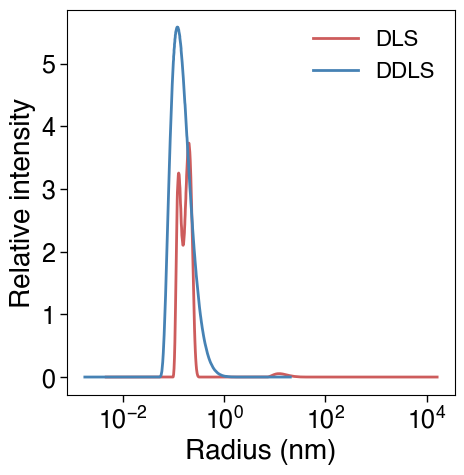

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(r_Aunrods_80_2_VV, rel_I_Aunrods_80_2_VV, c=c_l_DLS, linewidth=2, label= 'DLS')
#ax.plot(r_Aunrods_80_2_VV, cum_I_Aunrods_80_2_VV, c=c_l_DLS, linewidth=2, label= 'DLS')
ax.plot(r_Aunrods_80_2_VH, rel_I_Aunrods_80_2_VH, c=c_l_DDLS, linewidth=2, label= 'DDLS')

plt.xscale("log")
plt.xlabel('Radius (nm)', fontsize=20)
plt.ylabel('Relative intensity', fontsize=20)  
plt.legend(frameon=False, loc='best',fontsize=16)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
#plt.xlim(1E-5, 1E4)
#plt.ylim(-0.02, 1)
#plt.savefig("Size distribution ay 80deg.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

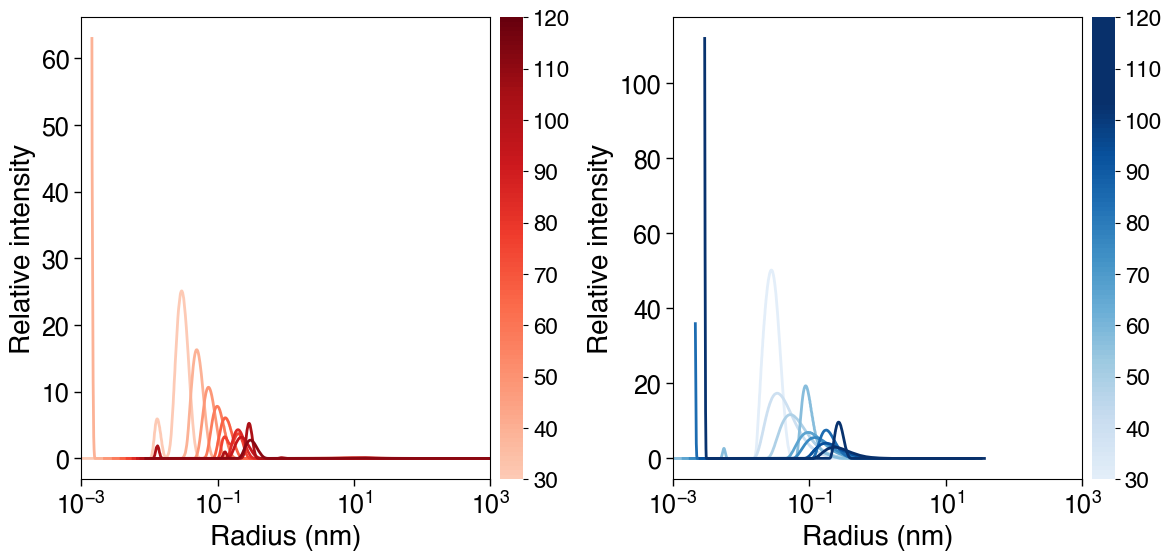

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


cmap_VV_0 = plt.get_cmap('Reds')
cmap_VV = ListedColormap(cmap_VV_0(np.linspace(0.2, 1.0, 100)))
cmap_VH_0 = plt.get_cmap('Blues')
cmap_VH = ListedColormap(cmap_VH_0(np.linspace(0.1, 1.2, 100)))

ax1 = axs[0]
for idx, (x, y, label) in enumerate(zip(r_Aunrods_VV, rel_I_Aunrods_VV, angles)):
    c = cmap_VV(float(idx) / len(r_Aunrods_VV))
    plot1 = ax1.plot(x, y, c=c, linewidth=2, label=label)

sm_VV = plt.cm.ScalarMappable(cmap=cmap_VV)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, ax=ax1, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

ax2 = axs[1]
for idx, (x, y, label) in enumerate(zip(r_Aunrods_VH, rel_I_Aunrods_VH, angles)):
    c = cmap_VH(float(idx) / len(r_Aunrods_VH))
    plot2 = ax2.plot(x, y, c=c, linewidth=2, label=label)

sm_VH = plt.cm.ScalarMappable(cmap=cmap_VH)
sm_VH.set_array([])
cbar_VH = plt.colorbar(sm_VH, ax=ax2, orientation='vertical', pad=0.02)
cbar_VH.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VH.set_ticks(ticks)
cbar_VH.set_ticklabels(tick_labels, fontsize=16)

for ax in axs.flat:
    ax.set_xscale("log")
    ax.set_xlabel('Radius (nm)', fontsize=20)
    ax.set_ylabel('Relative intensity', fontsize=20)
    #ax.legend(frameon=False, loc='best', fontsize=16)
    ax.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.set_xlim(1E-3, 1E3)
    #ax.set_ylim(-0.02, 1)
#plt.savefig("Size distribution.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

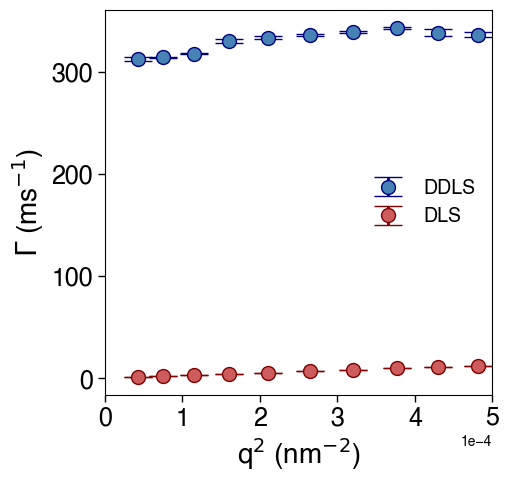

In [63]:
c_DLS = 'maroon'
c_l_DLS = 'indianred'
c_DDLS = 'navy'
c_l_DDLS = 'steelblue'

fig, ax = plt.subplots(figsize=(5, 5))
plt.errorbar(q2, average_gammas_VV_t, yerr=std_gammas_VV_t, fmt='o', markersize=10, capsize=10, linewidth=2,
             markerfacecolor=c_l_DDLS, markeredgecolor=c_DDLS, color=c_DDLS, label = 'DDLS')

plt.errorbar(q2, average_gammas_VV, yerr=std_gammas_VV, fmt='o', markersize=10, capsize=10, linewidth=2, 
             markerfacecolor=c_l_DLS, markeredgecolor=c_DLS, color=c_DLS, label = 'DLS')

plt.xlabel('q$^2$ (nm$^{-2}$)', fontsize=20)
plt.ylabel('$\Gamma$ (ms$^{-1}$)', fontsize=20)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 5E-4)
plt.legend(frameon = False, fontsize = 14)
#plt.title('Average Gamma vs. q2', fontsize=20)
plt.show()

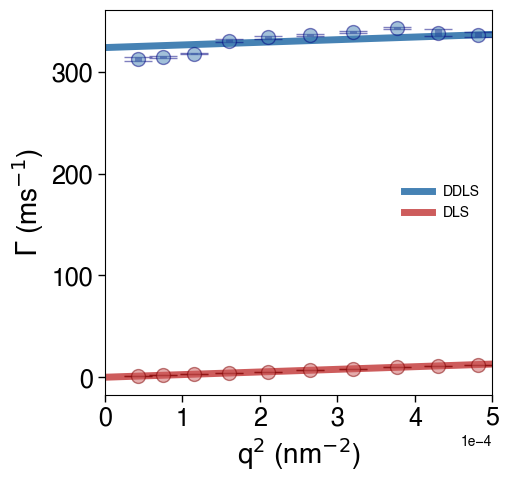

D_t from DLS (VV): 25897.35 nm^2/ms
D_r from DDLS (VH): 53.96 1/ms 



In [66]:
def linear_fit_VV(q_sq, D_t_VV, B):
    return D_t_VV * q_sq

popt_VV, pcov_VV = curve_fit(linear_fit_VV, q2, average_gammas_VV)
D_t_VV = popt_VV[0]

def linear_fit_VH(q_sq, D_r_VH):
    return D_t_VV * q_sq + 6 * D_r_VH 

popt_VH, pcov_VH = curve_fit(linear_fit_VH, q2, average_gammas_VV_t)
D_r_VH = popt_VH[0]

q2 = np.array(q2)
extrapolated_q2 = np.linspace(0, 0.0006, 100)
extrapolated_gammas_VV = linear_fit_VV(extrapolated_q2, *popt_VV)
extrapolated_gammas_VH = linear_fit_VH(extrapolated_q2, *popt_VH)

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(extrapolated_q2, extrapolated_gammas_VH, '-', linewidth=5, color=c_l_DDLS, label='DDLS')
plt.errorbar(q2, average_gammas_VV_t, yerr=std_gammas_VV_t, fmt='o', markersize=10, capsize=10, linewidth=5, 
             markerfacecolor=c_l_DDLS, markeredgecolor=c_DDLS, color=c_DDLS, alpha=0.5)

plt.plot(extrapolated_q2, extrapolated_gammas_VV, '-', linewidth=5, color=c_l_DLS, label='DLS')
plt.errorbar(q2, average_gammas_VV, yerr=std_gammas_VV, fmt='o', markersize=10, capsize=10, linewidth=5, 
             markerfacecolor=c_l_DLS, markeredgecolor=c_DLS, color=c_DLS, clip_on = False, alpha=0.5)

plt.xlabel('q$^2$ (nm$^{-2}$)', fontsize=20)
plt.ylabel('$\Gamma$ (ms$^{-1}$)', fontsize=20)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 5E-4)
#plt.title('Average Gamma vs. q2', fontsize=20)
plt.legend(frameon = False)
plt.show()

print(f'D_t from DLS (VV): {D_t_VV:.2f} nm^2/ms')
print(f'D_r from DDLS (VH): {D_r_VH:.2f} 1/ms \n')


$$
\Gamma = q^2D_T+6D_R
$$
\
$D_T$ = Translational diffusion coefficient

$D_R$ = Rotational diffusion coefficient 

Generalized equation for spherical:
$$
D_T = \frac{k_B T }{6 \pi \eta R}
$$
$$
D_R = \frac{k_B T }{8 \pi \eta R^3}
$$

Generalized equation for straight cylinders:
$$
D_T = \frac{k_B T }{3 \pi \eta L} f(\frac{L}{r})
$$
$$
D_R = \frac{3 k_B T }{\pi \eta L^3} f(\frac{L}{r})
$$

Proposed model for high aspect ratio rods with r<<L:
$$
D_T = \frac{k_B T }{6\pi \eta} \frac{ln(L/r)}{L}
$$

$$
D_R = \frac{k_B T }{8\pi \eta} \frac{ln(L/r)}{L^3}
$$

Rearrange the equations to find L and r:
$$
D_R = \frac{6}{8} {\frac{k_B T }{6\pi \eta} \frac{ln(L/r)}{L}} \frac{1}{L^2}
$$

$$
D_R = \frac{3}{4} D_T \frac{1}{L^2}
$$

$$
L^2 = \frac{3}{4} \frac{D_T}{D_R}
$$

$$
ln(L/r) = D_T \frac{6\pi \eta L}{k_B T}
$$

$$
\frac{L}{r} = exp(D_T \frac{6\pi \eta L}{k_B T})
$$

$$
r = \frac{L}{exp(D_T \frac{6\pi \eta L}{k_B T})}
$$

L= 18.97 nm
r= 1.3396e+00 nm
Aspect ratio: 14.16



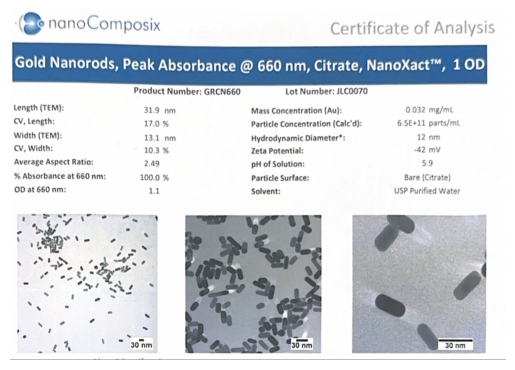

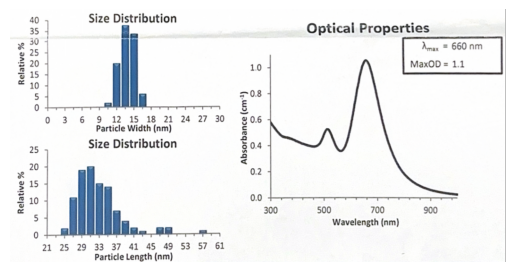

The data analysis is still not accurate. Might need to remeasure them.
Source: Directly provided by the vendor from NanoComposix


In [67]:
D_t = D_t_VV*1e-18/1e-3   #m^2/s
D_r = D_r_VH/1e-3         #1/s
eta = 1.1375e-3           #Pa*s
T_C = 15                  #C
T_K = T_C+273             #K
pi = np.pi
                          #1 Joule = 1 Pa.m3
kB = 1.38e-23             #J/K = Pa.m3/K
L = np.sqrt((3*D_t)/(4*D_r))
L_nm = L*1e9
print(f"L= {L_nm:.2f} nm")

#ln_L_r = (D_r * 8 * pi * eta * L**3) / (kB * T_K)
ln_L_r = (D_t * 6 * pi * eta * L) / (kB * T_K)
AR = np.exp(ln_L_r)
r = L / AR
r_nm = r*1e9
print(f"r= {r_nm:.4e} nm")

print(f"Aspect ratio: {AR:.2f}\n") 

img = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Au NR.png')

plt.imshow(img)
plt.axis('off')  
plt.show()

img = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Au NR 2.png')

plt.imshow(img)
plt.axis('off')  
plt.show()
print("The data analysis is still not accurate. Might need to remeasure them.")
print("Source: Directly provided by the vendor from NanoComposix")

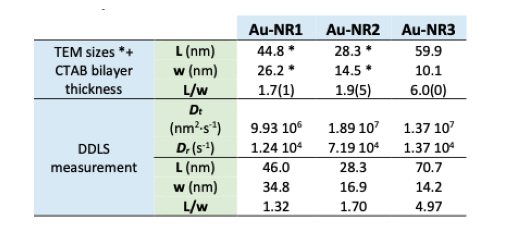

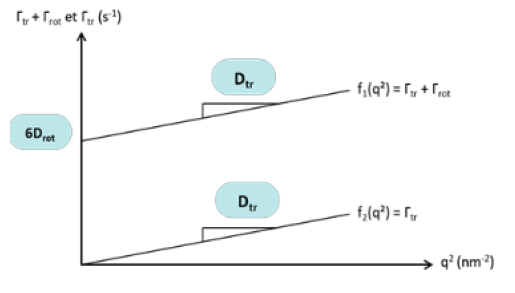

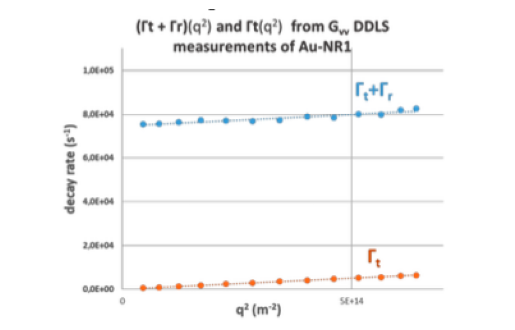

Source: Benoit Maxit, Clara Catros, Florian Aubrit, Julien Le Mener, Olivier Sandre, et al New methodology for anisotropic nanoparticles characterization by polarization light scattering: length and diameter determination of rod-like nanoparticles. Conference of Science & Technology for Integrated Circuits (CSTIC2024) – Symposium VI: Metrology, Reliability and Testing, SEMICON China, Mar 2024, Shanghai (Chine), China. hal-04263744v2


In [493]:
img = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Screenshot 2024-06-20 at 11.16.31 AM.png')

plt.imshow(img)
plt.axis('off')  
plt.show()
img2 = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Screenshot 2024-06-20 at 11.16.42 AM.png')
plt.imshow(img2)
plt.axis('off')  
plt.show()
img3 = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Screenshot 2024-06-20 at 11.16.50 AM.png')
plt.imshow(img3)
plt.axis('off')  
plt.show()
print('Source: Benoit Maxit, Clara Catros, Florian Aubrit, Julien Le Mener, Olivier Sandre, et al New methodology for anisotropic nanoparticles characterization by polarization light scattering: length and diameter determination of rod-like nanoparticles. Conference of Science & Technology for Integrated Circuits (CSTIC2024) – Symposium VI: Metrology, Reliability and Testing, SEMICON China, Mar 2024, Shanghai (Chine), China. hal-04263744v2')

# Non-ergodic DLS
## Determination of the mesh size of gels

In [189]:
#Regular DLS measurements

Gel_105_1 = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels DLS/Measurement 6/Repetition1/Correlation Function.csv', header=None, skiprows=[0, 1, 2])
Gel_105_2 = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels DLS/Measurement 6/Repetition2/Correlation Function.csv', header=None, skiprows=[0, 1, 2])
Gel_105_3 = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels DLS/Measurement 6/Repetition3/Correlation Function.csv', header=None, skiprows=[0, 1, 2])

t_gel_105_1 = Gel_105_1.iloc[0:, 0]
t_gel_105_ms_1 = t_gel_105_1 * 1000 
g_105_1 = Gel_105_1.iloc[0:, 1]

t_gel_105_2 = Gel_105_2.iloc[0:, 0]
t_gel_105_ms_2 = t_gel_105_2 * 1000 
g_105_2 = Gel_105_2.iloc[0:, 1]

t_gel_105_3 = Gel_105_3.iloc[0:, 0]
t_gel_105_ms_3 = t_gel_105_3 * 1000 
g_105_3 = Gel_105_3.iloc[0:, 1]

base_path_gel = '/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels DLS/Measurement'

angle_info_gel = {
    30: (1, 3),
    45: (2, 1),
    60: (3, 1),
    75: (4, 3),
    90: (5, 1),
    105: (6, 1),
    120: (7, 1)
}

for angle, (measurement, repetition) in angle_info_gel.items():
    file_path = f'{base_path_gel} {measurement}/Repetition{repetition}/Correlation Function.csv'
    globals()[f'Gel_{angle}'] = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

t_gel_ms = []
g_gel = []
angle_gel = [30, 45, 60, 75, 90, 105, 120]

for a in angle_gel:
    t_gel = globals()[f"Gel_{a}"].iloc[0:, 0]
    globals()[f"t_gel_{a}_ms"] = t_gel * 1000 
    t_gel_ms.append(globals()[f"t_gel_{a}_ms"])
    
    g_gel_data = globals()[f"Gel_{a}"].iloc[0:, 1]
    globals()[f"g_gel_{a}"] = g_gel_data 
    g_gel.append(globals()[f"g_gel_{a}"])

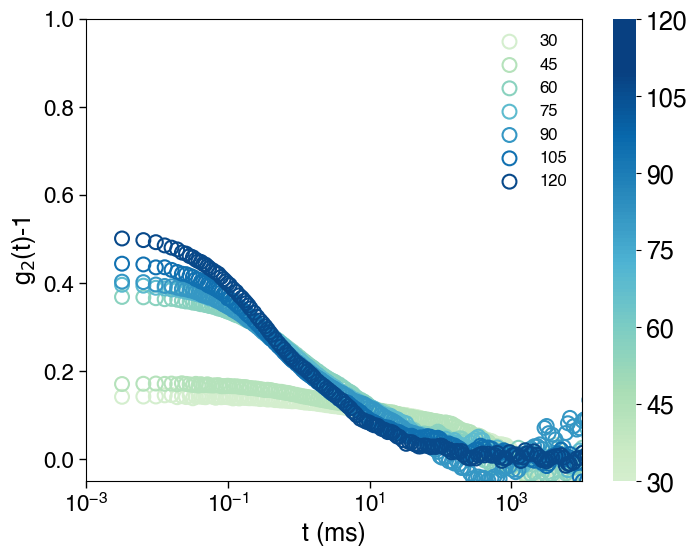

In [190]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('GnBu')
cmap_gel_DLS = ListedColormap(cmap(np.linspace(0.2, 1.1, 120)))


for idx, (x, y, label) in enumerate(zip(t_gel_ms, g_gel, angle_gel)):
    c = cmap_gel_DLS(float(idx) / len(t_gel_ms))
    scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=100, linewidths=1.5, label=label)
    scatter1.set_facecolor('none')
    
sm = plt.cm.ScalarMappable(cmap=cmap_gel_DLS)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.outline.set_visible(False)


ticks = np.linspace(0, 1, len(angle_gel))
tick_labels = angle_gel
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels, fontsize=18)

#ticks = np.linspace(0, 1, len(q_3f))
#tick_labels = q_3f
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(tick_labels)

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
plt.legend(frameon=False, loc='best',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

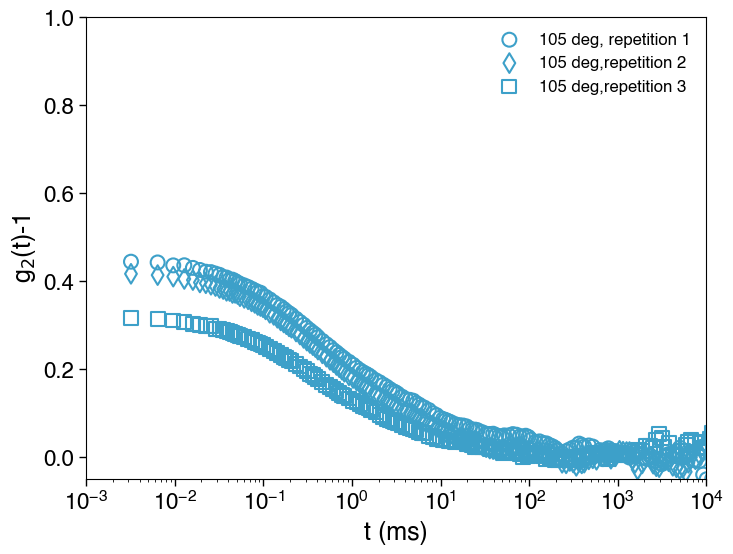

In [191]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('GnBu')
cmap_gel_DLS = ListedColormap(cmap(np.linspace(0.2, 1.1, 120)))

fifth_color = cmap_gel_DLS(np.linspace(0.2, 1.0, 120))[50]

scatter1 = ax.scatter(t_gel_105_ms_1, g_105_1, marker='o', facecolors=fifth_color, edgecolors=fifth_color, 
                      s=100, linewidths=1.5, label='105 deg, repetition 1')
scatter1.set_facecolor('none')
scatter2 = ax.scatter(t_gel_105_ms_2, g_105_2, marker='d', facecolors=fifth_color, edgecolors=fifth_color, 
                          s=100, linewidths=1.5, label='105 deg,repetition 2')
scatter2.set_facecolor('none')
scatter3 = ax.scatter(t_gel_105_ms_3, g_105_3, marker='s', facecolors=fifth_color, edgecolors=fifth_color, 
                          s=100, linewidths=1.5, label='105 deg,repetition 3')
scatter3.set_facecolor('none')

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
plt.legend(frameon=False, loc='best',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

In [192]:
#Non-ergodic DLS measurements
Gel_NE_105_1 = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels NE DLS/Measurement 6/Repetition1/Correlation Function.csv', header=None, skiprows=[0, 1, 2])
Gel_NE_105_2 = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels NE DLS/Measurement 6/Repetition2/Correlation Function.csv', header=None, skiprows=[0, 1, 2])
Gel_NE_105_3 = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels NE DLS/Measurement 6/Repetition3/Correlation Function.csv', header=None, skiprows=[0, 1, 2])

t_gel_NE_105_1 = Gel_NE_105_1.iloc[0:, 0]
t_gel_NE_105_ms_1 = t_gel_NE_105_1 * 1000 
g_NE_105_1 = Gel_NE_105_1.iloc[0:, 1]

t_gel_NE_105_2 = Gel_NE_105_2.iloc[0:, 0]
t_gel_NE_105_ms_2 = t_gel_NE_105_2 * 1000 
g_NE_105_2 = Gel_NE_105_2.iloc[0:, 1]

t_gel_NE_105_3 = Gel_NE_105_3.iloc[0:, 0]
t_gel_NE_105_ms_3 = t_gel_NE_105_3 * 1000 
g_NE_105_3 = Gel_NE_105_3.iloc[0:, 1]

base_path_gel_NE = '/Users/ningravi/Desktop/Python/RawData/Standard Particles/CNF gels NE DLS/Measurement'

angle_info_gel_NE = {
    30: (1, 1),
    45: (2, 1),
    60: (3, 2),
    75: (4, 1),
    90: (5, 1),
    105: (6, 2),
    120: (7, 1)
}

for angle, (measurement, repetition) in angle_info_gel_NE.items():
    file_path = f'{base_path_gel_NE} {measurement}/Repetition{repetition}/Correlation Function.csv'
    globals()[f'Gel_NE_{angle}'] = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

t_gel_NE_ms = []
g_gel_NE = []
angle_gel_NE = [30, 45, 60, 75, 90, 105, 120]

for a in angle_gel_NE:
    t_gel_NE = globals()[f"Gel_NE_{a}"].iloc[0:, 0]
    globals()[f"t_gel_NE_{a}_ms"] = t_gel_NE * 1000 
    t_gel_NE_ms.append(globals()[f"t_gel_NE_{a}_ms"])
    
    g_gel_NE_data = globals()[f"Gel_NE_{a}"].iloc[0:, 1]
    globals()[f"g_gel_NE_{a}"] = g_gel_NE_data 
    g_gel_NE.append(globals()[f"g_gel_NE_{a}"])

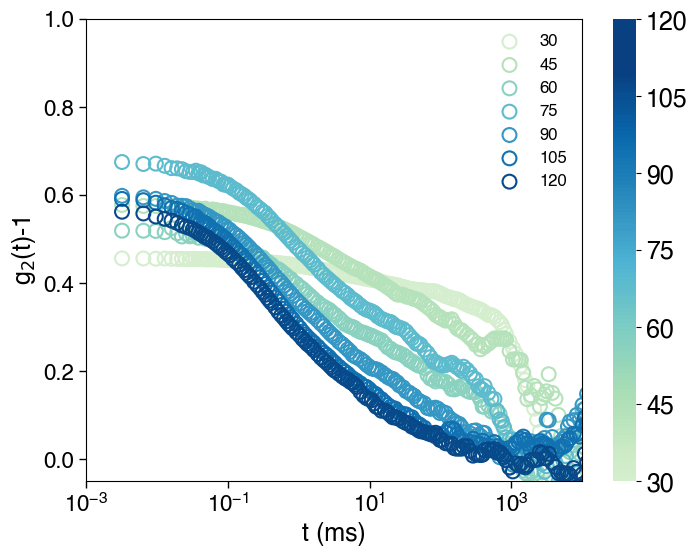

In [197]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('GnBu')
cmap_gel_DLS = ListedColormap(cmap(np.linspace(0.2, 1.1, 120)))


for idx, (x, y, label) in enumerate(zip(t_gel_NE_ms, g_gel_NE, angle_gel_NE)):
    c = cmap_gel_DLS(float(idx) / len(t_gel_NE_ms))
    scatter1 = ax.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=100, linewidths=1.5, label=label)
    scatter1.set_facecolor('none')
    
sm = plt.cm.ScalarMappable(cmap=cmap_gel_DLS)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.outline.set_visible(False)


ticks = np.linspace(0, 1, len(angle_gel))
tick_labels = angle_gel
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels, fontsize=18)

#ticks = np.linspace(0, 1, len(q_3f))
#tick_labels = q_3f
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(tick_labels)

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
plt.legend(frameon=False, loc='best',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

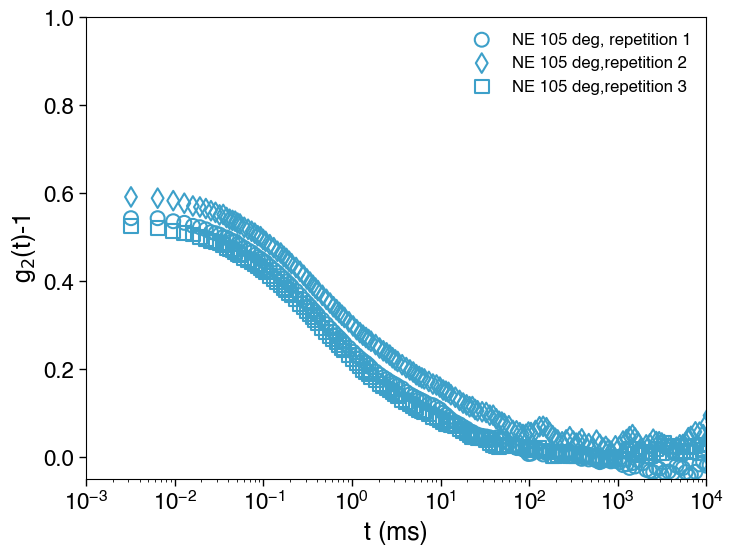

In [198]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('GnBu')
cmap_gel_DLS = ListedColormap(cmap(np.linspace(0.2, 1.1, 120)))

fifth_color = cmap_gel_DLS(np.linspace(0.2, 1.0, 120))[50]

scatter1 = ax.scatter(t_gel_NE_105_ms_1, g_NE_105_1, marker='o', facecolors=fifth_color, edgecolors=fifth_color, 
                      s=100, linewidths=1.5, label='NE 105 deg, repetition 1')
scatter1.set_facecolor('none')
scatter2 = ax.scatter(t_gel_NE_105_ms_2, g_NE_105_2, marker='d', facecolors=fifth_color, edgecolors=fifth_color, 
                          s=100, linewidths=1.5, label='NE 105 deg,repetition 2')
scatter2.set_facecolor('none')
scatter3 = ax.scatter(t_gel_NE_105_ms_3, g_NE_105_3, marker='s', facecolors=fifth_color, edgecolors=fifth_color, 
                          s=100, linewidths=1.5, label='NE 105 deg,repetition 3')
scatter3.set_facecolor('none')

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=18)
plt.ylabel('g$_2$(t)-1', fontsize=18)  
plt.legend(frameon=False, loc='best',fontsize=12)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=16)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=16)
plt.xlim(1E-3, 1E4)
plt.ylim(-0.05, 1)
#plt.savefig("Correlation function VS lag time SiO2.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

# SLS 
## Determination of radius of gyration
#### Radius of Gyration and Guinier Law

In this module, there are also two systems to demonstrate the data analysis including (1) colloidal polystyrene dispersed in water and (2) colloidal silica nanoparticles (LUDOX TW-50) dispersed in water. The former is very accurate to measure the nanoparticle size but the later one is so much higher than the number reported on their SDS document. 

### Colloidal Polystyrene

In [456]:
PS100 = pd.read_csv('/Users/ningravi/Desktop/Python/CBE570_ls_lab/SLS PS.csv', header= None, skiprows=[0,1,2,3])

PS100_theta_angle = PS100.iloc[3:,13]
PS100_I_wave = PS100.iloc[3:,4]
PS100_theta = [float(theta) for theta in PS100_theta_angle]
PS100_theta_radian = np.deg2rad(PS100_theta)
PS100_I = [float(I) for I in PS100_I_wave]
PS100_lnI = [np.log(I) for I in PS100_I]

n = 1.33
lambd = 660 #nm

PS100_q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in PS100_theta_radian]
PS100_q2 = [q**2 for q in PS100_q]

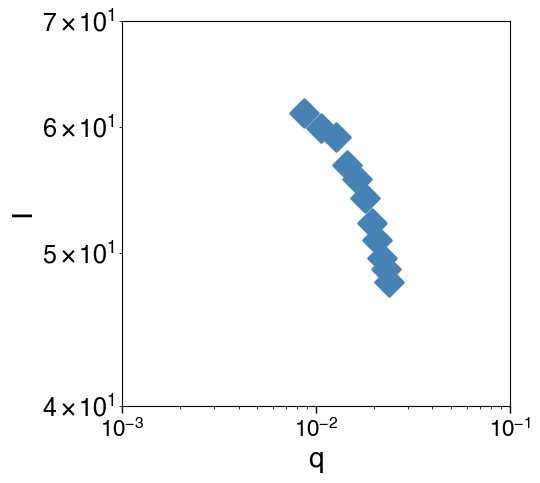

In [457]:
c_PS = 'steelblue'

fig, ax = plt.subplots(figsize=(5, 5))
PS_scatter = ax.scatter(PS100_q, PS100_I, s=200, alpha=1, marker='D', 
                        facecolors=c_PS, edgecolors=c_PS, linewidths=2, clip_on=False)
#PS_scatter.set_facecolor('none')

plt.xlabel('q', fontsize=20)
plt.ylabel('I', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-2, -2))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='both', which='minor', labelsize=18) 
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.001, 0.1)
plt.ylim(40, 70)
plt.xscale("log")
plt.yscale("log")
#plt.savefig("PS suspension I vs q.png", dpi=1500, bbox_inches='tight')
plt.show()

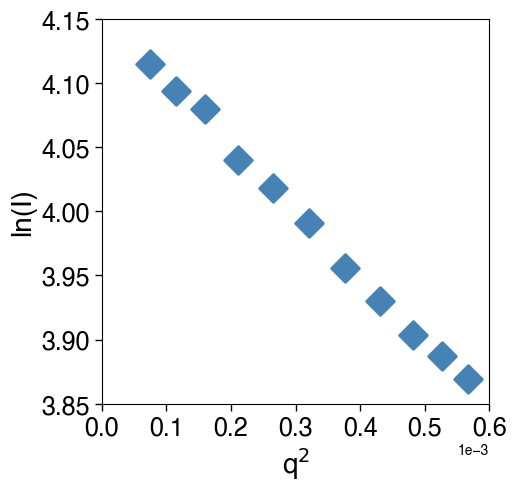

In [458]:
c_PS = 'steelblue'

fig, ax = plt.subplots(figsize=(5, 5))
PS_scatter = ax.scatter(PS100_q2, PS100_lnI, s=200, alpha=1, marker='D', 
                        facecolors=c_PS, edgecolors=c_PS, linewidths=2, clip_on=False)
#PS_scatter.set_facecolor('none')

plt.xlabel('q$^2$', fontsize=20)
plt.ylabel('ln(I)', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-3, -3))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(3.85, 4.15)
plt.xlim(0, 0.0006)
#plt.xscale("log")
#plt.yscale("log")
plt.show()

The chracteristis of objects are encoded in the low q scattering via radius of gyration calculated as the root mean square distance of the object's parts from its center of gravity.


Guinier Law (valid when $qR_g<1.3$):

$$
I(q→0)\sim I_0 exp(\frac{−q^2R_g^2}{3})
$$

Linearize it

$$
ln⁡(𝐼(𝑞)) ≈ −\frac{𝑞^2 𝑅_𝑔^2}{3}+ln(⁡𝐼(0))
$$

Or
$$
𝑃(𝑞)≃1−\frac{(𝑞𝑅_𝑔 )^2}{3}
$$

Note: the Guinier region of the scattering data would not be linear if sample contains aggregation

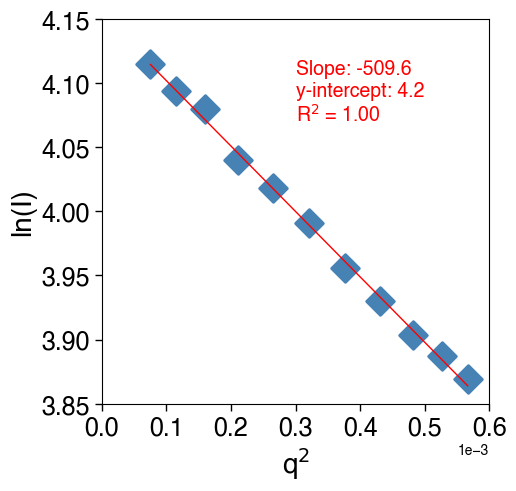

Fitted Parameters:
Slope:, -509.63
Intercept:, 4.15
R2 = 0.9973


In [459]:
def linear_equation(x, m, c):
    return m * x + c


popt_PS_sls, pcov_PS_sls = curve_fit(linear_equation, PS100_q2, PS100_lnI)

slope_PS_sls, intercept_PS_sls = popt_PS_sls

x_PS_sls = np.linspace(min(PS100_q2), max(PS100_q2), 100)
y_PS_sls = slope_PS_sls * x_PS_sls + intercept_PS_sls

PS100_q2 = np.array(PS100_q2)

y_pred_PS_sls = linear_equation(PS100_q2, slope_PS_sls, intercept_PS_sls)

r_squared_PS_sls = r2_score(PS100_lnI, y_pred_PS_sls[:len(PS100_lnI)])

c_PS = 'steelblue'

fig, ax = plt.subplots(figsize=(5, 5))

PS_scatter = ax.scatter(PS100_q2, PS100_lnI, s=200, alpha=1, marker='D', 
                        facecolors=c_PS, edgecolors=c_PS, linewidths=2, clip_on=False)
#PS_scatter.set_facecolor('none')

ax.plot(x_PS_sls, y_PS_sls, color='red', linestyle='-', linewidth=1)

plt.xlabel('q$^2$', fontsize=20)
plt.ylabel('ln(I)', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-3, -3))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(3.85, 4.15)
plt.xlim(0, 0.0006)
plt.text(0.3e-3, 4.07, f"Slope: {slope_PS_sls:.1f}\ny-intercept: {intercept_PS_sls:.1f}\nR$^2$ = {r_squared_PS_sls:.2f}",
         fontsize=14, c='red')
#plt.savefig("PS suspension ln(I) vs q2.png", dpi=1500, bbox_inches='tight')
plt.show()

print("Fitted Parameters:")
print(f"Slope:, {slope_PS_sls:.2f}\nIntercept:, {intercept_PS_sls:.2f}\nR2 = {r_squared_PS_sls:.4f}")

In [460]:
PS_Rg = np.sqrt(-slope_PS_sls * 3)

print(f"PS_Rg: {PS_Rg:.2f} nm")

R = np.sqrt(5/3*PS_Rg**2)
D = 2*R
print(f"R: {R:.2f} nm")
print(f"D: {D:.2f} nm")

PS_Rg: 39.10 nm
R: 50.48 nm
D: 100.96 nm


$$
R_g \sim 39 \ nm
$$ 

$$
R_g^2 = \frac{3}{5}R^2
$$

$$
R = (\frac{5}{3}R_g^2)^{1/2}
$$

$$
R_{actual} \sim  50 \ nm
$$

$$
D_{actual} \sim  100 \ nm
$$

### Comparison Different Sizes

In [461]:
PS = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns/PS 0.1 microns.csv', header= None, skiprows=[0,1,2,3])

PS_theta_angle = PS.iloc[1:,13]
PS_I_wave = PS.iloc[1:,4]
PS_theta = [float(theta) for theta in PS_theta_angle]
PS_theta_radian = np.deg2rad(PS_theta)
PS_I = [float(I) for I in PS_I_wave]
PS_lnI = [np.log(I) for I in PS_I]

n = 1.33
lambd = 660 #nm

PS_q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in PS_theta_radian]
PS_q2 = [q**2 for q in PS_q]

PS_f = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 0.1 microns + fluoro/PS 0.1 microns fluoro.csv', header= None, skiprows=[0,1,2,3])

PS_f_theta_angle = PS_f.iloc[1:,13]
PS_f_I_wave = PS_f.iloc[1:,4]
PS_f_theta = [float(theta) for theta in PS_f_theta_angle]
PS_f_theta_radian = np.deg2rad(PS_f_theta)
PS_f_I = [float(I) for I in PS_f_I_wave]
PS_f_lnI = [np.log(I) for I in PS_f_I]

PS_f_q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in PS_f_theta_radian]
PS_f_q2 = [q**2 for q in PS_f_q]

PS_l = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/Standard Particles/PS 1 microns/PS 1 microns.csv', header= None, skiprows=[0,1,2,3])

PS_l_theta_angle = PS_l.iloc[1:,13]
PS_l_I_wave = PS_l.iloc[1:,4]
PS_l_theta = [float(theta) for theta in PS_l_theta_angle]
PS_l_theta_radian = np.deg2rad(PS_l_theta)
PS_l_I = [float(I) for I in PS_l_I_wave]
PS_l_lnI = [np.log(I) for I in PS_l_I]

PS_l_q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in PS_l_theta_radian]
PS_l_q2 = [q**2 for q in PS_l_q]

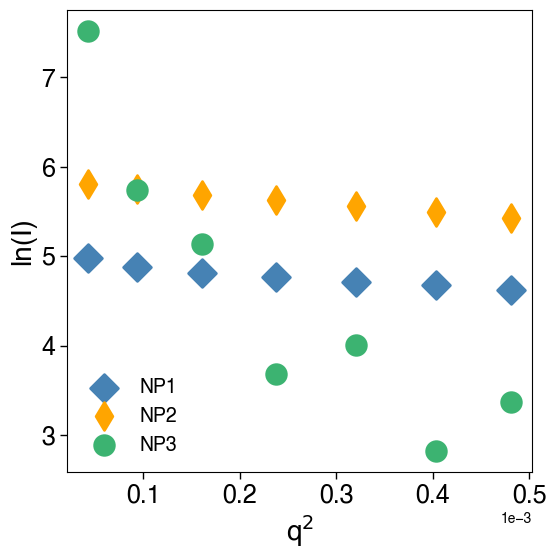

In [462]:
c1 = 'steelblue'
c2 = 'orange'
c3 = 'mediumseagreen'

fig, ax = plt.subplots(figsize=(6, 6))
PS_scatter = ax.scatter(PS_q2, PS_lnI, s=200, alpha=1, marker='D', 
                        facecolors=c1, edgecolors=c1, linewidths=2, clip_on=False, label="NP1")
PS_f_scatter = ax.scatter(PS_f_q2, PS_f_lnI, s=200, alpha=1, marker='d', 
                        facecolors=c2, edgecolors=c2, linewidths=2, clip_on=False, label="NP2")
PS_l_scatter = ax.scatter(PS_l_q2, PS_l_lnI, s=200, alpha=1, marker='o', 
                        facecolors=c3, edgecolors=c3, linewidths=2, clip_on=False, label="NP3")
#PS_scatter.set_facecolor('none')

plt.xlabel('q$^2$', fontsize=20)
plt.ylabel('ln(I)', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-3, -3))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(3.85, 4.15)
#plt.xlim(0, 0.0006)
#plt.xscale("log")
#plt.yscale("log")
plt.legend(frameon=False, loc='lower left',fontsize=14)
plt.show()

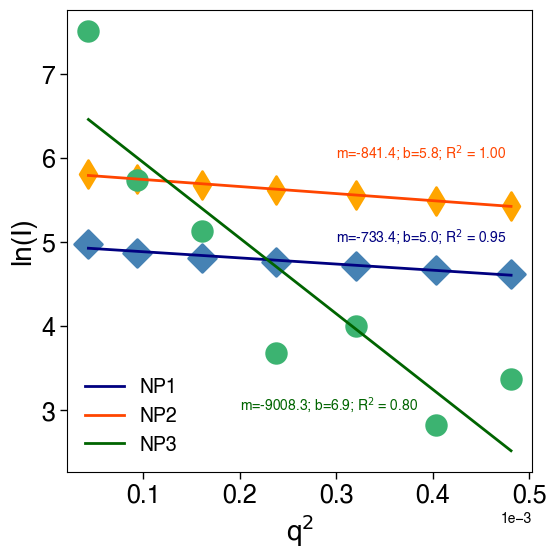

In [463]:
def linear_equation(x, m, c):
    return m * x + c

PS_q2 = np.array(PS_q2)
PS_lnI = np.array(PS_lnI)

popt_PS_sls, pcov_PS_sls = curve_fit(linear_equation, PS_q2, PS_lnI)
slope_PS_sls, intercept_PS_sls = popt_PS_sls

x_PS_sls = np.linspace(min(PS_q2), max(PS_q2), 100)
y_PS_sls = linear_equation(x_PS_sls, slope_PS_sls, intercept_PS_sls)

y_pred_PS_sls = linear_equation(PS_q2, slope_PS_sls, intercept_PS_sls)
r_squared_PS_sls = r2_score(PS_lnI, y_pred_PS_sls)

PS_f_q2 = np.array(PS_f_q2)
PS_f_lnI = np.array(PS_f_lnI)

popt_PS_f_sls, pcov_PS_f_sls = curve_fit(linear_equation, PS_f_q2, PS_f_lnI)
slope_PS_f_sls, intercept_PS_f_sls = popt_PS_f_sls

x_PS_f_sls = np.linspace(min(PS_f_q2), max(PS_f_q2), 100)
y_PS_f_sls = linear_equation(x_PS_f_sls, slope_PS_f_sls, intercept_PS_f_sls)

y_pred_PS_f_sls = linear_equation(PS_f_q2, slope_PS_f_sls, intercept_PS_f_sls)
r_squared_PS_f_sls = r2_score(PS_f_lnI, y_pred_PS_f_sls)

PS_l_q2 = np.array(PS_l_q2)
PS_l_lnI = np.array(PS_l_lnI)

popt_PS_l_sls, pcov_PS_l_sls = curve_fit(linear_equation, PS_l_q2, PS_l_lnI)
slope_PS_l_sls, intercept_PS_l_sls = popt_PS_l_sls

x_PS_l_sls = np.linspace(min(PS_l_q2), max(PS_l_q2), 100)
y_PS_l_sls = linear_equation(x_PS_l_sls, slope_PS_l_sls, intercept_PS_l_sls)

y_pred_PS_l_sls = linear_equation(PS_l_q2, slope_PS_l_sls, intercept_PS_l_sls)
r_squared_PS_l_sls = r2_score(PS_l_lnI, y_pred_PS_l_sls)


c1 = 'steelblue'
c2 = 'orange'
c3 = 'mediumseagreen'

fig, ax = plt.subplots(figsize=(6, 6))

PS_scatter = ax.scatter(PS_q2, PS_lnI, s=200, alpha=1, marker='D', 
                        facecolors=c1, edgecolors=c1, linewidths=2, clip_on=False)
PS_f_scatter = ax.scatter(PS_f_q2, PS_f_lnI, s=200, alpha=1, marker='d', 
                        facecolors=c2, edgecolors=c2, linewidths=2, clip_on=False)
PS_l_scatter = ax.scatter(PS_l_q2, PS_l_lnI, s=200, alpha=1, marker='o', 
                        facecolors=c3, edgecolors=c3, linewidths=2, clip_on=False)

ax.plot(x_PS_sls, y_PS_sls, color='navy', linestyle='-', linewidth=2, label='NP1')
plt.text(0.3e-3, 5, f"m={slope_PS_sls:.1f}; b={intercept_PS_sls:.1f}; R$^2$ = {r_squared_PS_sls:.2f}", c="navy")

ax.plot(x_PS_f_sls, y_PS_f_sls, color='orangered', linestyle='-', linewidth=2, label='NP2')
plt.text(0.3e-3, 6, f"m={slope_PS_f_sls:.1f}; b={intercept_PS_f_sls:.1f}; R$^2$ = {r_squared_PS_f_sls:.2f}", c="orangered")

ax.plot(x_PS_l_sls, y_PS_l_sls, color='darkgreen', linestyle='-', linewidth=2, label='NP3')
plt.text(0.2e-3, 3, f"m={slope_PS_l_sls:.1f}; b={intercept_PS_l_sls:.1f}; R$^2$ = {r_squared_PS_l_sls:.2f}", c="darkgreen")

plt.xlabel('q$^2$', fontsize=20)
plt.ylabel('ln(I)', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-3, -3))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(3.85, 4.15)
#plt.xlim(0, 0.0006)
#plt.xscale("log")
#plt.yscale("log")
plt.legend(frameon=False, loc='lower left',fontsize=14)
plt.show()

In [464]:
print(f"For PS 1")
PS1_Rg = np.sqrt(-slope_PS_sls * 3)

print(f"Rg: {PS1_Rg:.2f} nm")

R1 = np.sqrt(5/3*PS1_Rg**2)
D1 = 2*R1
print(f"R: {R1:.2f} nm")
print(f"D: {D1:.2f} nm\n")

print(f"For PS 2")
PS2_Rg = np.sqrt(-slope_PS_f_sls * 3)

print(f"Rg: {PS2_Rg:.2f} nm")

R2 = np.sqrt(5/3*PS2_Rg**2)
D2 = 2*R2
print(f"R: {R2:.2f} nm")
print(f"D: {D2:.2f} nm\n")

print(f"For PS 3")
PS3_Rg = np.sqrt(-slope_PS_l_sls * 3)

print(f"Rg: {PS3_Rg:.2f} nm")

R3 = np.sqrt(5/3*PS3_Rg**2)
D3 = 2*R3
print(f"R: {R3:.2f} nm")
print(f"D: {D3:.2f} nm")

For PS 1
Rg: 46.91 nm
R: 60.56 nm
D: 121.11 nm

For PS 2
Rg: 50.24 nm
R: 64.86 nm
D: 129.72 nm

For PS 3
Rg: 164.39 nm
R: 212.23 nm
D: 424.46 nm


### Colloidal Silica: LUDOX TM50

In [26]:
Si22 = pd.read_csv('/Users/ningravi/Desktop/Python/CBE570_ls_lab/Ludox/SiO2_0.5/SLS_ludox_0.5.csv', header= None, skiprows=[0,1,2,3])

Si22_theta_angle = Si22.iloc[3:,13]
Si22_I_wave = Si22.iloc[3:,4]
Si22_theta = [float(theta) for theta in Si22_theta_angle]
Si22_theta_radian = np.deg2rad(Si22_theta)
Si22_I = [float(I) for I in Si22_I_wave]
Si22_lnI = [np.log(I) for I in Si22_I]

n = 1.33
lambd = 660 #nm

Si22_q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in Si22_theta_radian]
Si22_q2 = [q**2 for q in Si22_q]

#print(Si22_theta_angle)

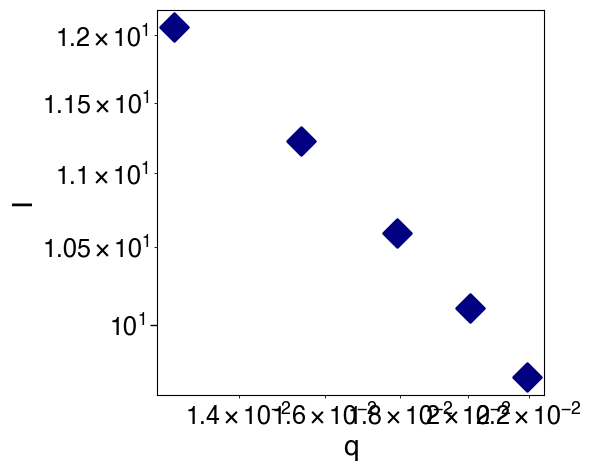

In [465]:
c_Si = 'navy'

fig, ax = plt.subplots(figsize=(5, 5))
PS_scatter = ax.scatter(Si22_q, Si22_I, s=200, alpha=1, marker='D', 
                        facecolors=c_Si, edgecolors=c_Si, linewidths=2, clip_on=False)

plt.xlabel('q', fontsize=20)
plt.ylabel('I', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-2, -2))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='both', which='minor', labelsize=18) 
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlim(0.001, 0.1)
#plt.ylim(46, 70)
plt.xscale("log")
plt.yscale("log")
#plt.savefig("PS suspension I vs q.png", dpi=1500, bbox_inches='tight')
plt.show()

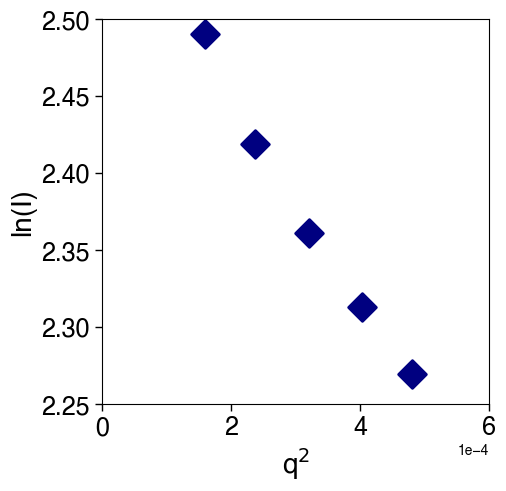

In [466]:
c_Si = 'navy'

fig, ax = plt.subplots(figsize=(5, 5))
PS_scatter = ax.scatter(Si22_q2, Si22_lnI, s=200, alpha=1, marker='D', 
                        facecolors=c_Si, edgecolors=c_Si, linewidths=2, clip_on=False)

plt.xlabel('q$^2$', fontsize=20)
plt.ylabel('ln(I)', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='both', labelsize=18) 
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 0.0006)
plt.ylim(2.25, 2.5)
#plt.xscale("log")
#plt.yscale("log")
plt.show()

The chracteristis of objects are encoded in the low q scattering via radius of gyration calculated as the root mean square distance of the object's parts from its center of gravity.


Guinier Law (valid when $qR_g<1.3$):

$$
I(q→0)\sim I_0 exp(\frac{−q^2R_g^2}{3})
$$

Linearize it

$$
ln⁡(𝐼(𝑞)) ≈ −\frac{𝑞^2 𝑅_𝑔^2}{3}+ln(⁡𝐼(0))
$$

Or
$$
𝑃(𝑞)≃1−\frac{(𝑞𝑅_𝑔 )^2}{3}
$$

Note: the Guinier region of the scattering data would not be linear if sample contains aggregation

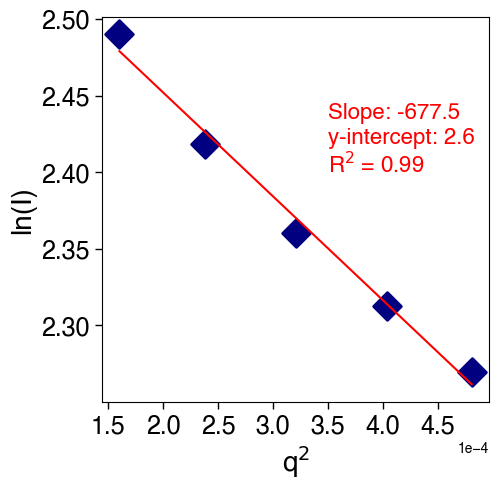

Fitted Parameters:
Slope:, -677.54
Intercept:, 2.59
R2 = 0.9888


In [467]:
def linear_equation(x, m, c):
    return m * x + c


popt_Si_sls, pcov_Si_sls = curve_fit(linear_equation, Si22_q2, Si22_lnI)

slope_Si_sls, intercept_Si_sls = popt_Si_sls

x_Si_sls = np.linspace(min(Si22_q2), max(Si22_q2), 100)
y_Si_sls = slope_Si_sls * x_Si_sls + intercept_Si_sls

Si22_q2 = np.array(Si22_q2)

y_pred_Si_sls = linear_equation(Si22_q2, slope_Si_sls, intercept_Si_sls)

r_squared_Si_sls = r2_score(Si22_lnI, y_pred_Si_sls[:len(Si22_lnI)])


fig, ax = plt.subplots(figsize=(5, 5))

PS_scatter = ax.scatter(Si22_q2, Si22_lnI, s=200, alpha=1, marker='D', 
                        facecolors=c_Si, edgecolors=c_Si, linewidths=2, clip_on=False)

ax.plot(x_Si_sls, y_Si_sls, color='red', linestyle='-')


plt.xlabel('q$^2$', fontsize=20)
plt.ylabel('ln(I)', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='both', which='minor', labelsize=18) 
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlim(1, 100)
#plt.ylim(-3, 0.5)
#plt.xscale("log")
#plt.yscale("log")
plt.text(0.35e-3, 2.4, f"Slope: {slope_Si_sls:.1f}\ny-intercept: {intercept_Si_sls:.1f}\nR$^2$ = {r_squared_Si_sls:.2f}", 
         fontsize=16, c='red')
#plt.savefig("SiO2 suspension ln(I) vs q2.png", dpi=1500, bbox_inches='tight')
plt.show()

print("Fitted Parameters:")
print(f"Slope:, {slope_Si_sls:.2f}")
print(f"Intercept:, {intercept_Si_sls:.2f}")
print(f"R2 = {r_squared_Si_sls:.4f}")

In [468]:
Si_Rg = np.sqrt(-slope_Si_sls * 3)

print(f"Si_Rg: {Si_Rg:.2f} nm")

R_Si = np.sqrt(5/3*Si_Rg**2)
D_Si = 2*R_Si
print(f"R: {R_Si:.2f} nm")
print(f"D: {D_Si:.2f} nm")

Si_Rg: 45.08 nm
R: 58.20 nm
D: 116.41 nm


## Determination of MW, Rg and A2
### Refractometer

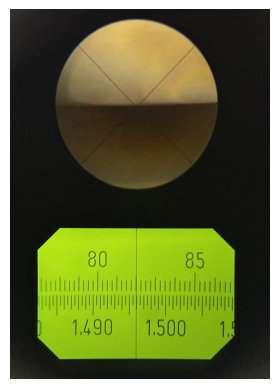

In [487]:
img = mpimg.imread('/Users/ningravi/Desktop/Python/Refractometer/Toluene.jpg')

plt.imshow(img)
plt.axis('off')  
plt.show()

In [488]:
PolymerSol_SLS_Zimm = '/Users/ningravi/Desktop/Python/CBE570_ls_lab/LS_Demo_20240404.xlsx'

In [489]:
PS_conc_values = pd.read_excel(PolymerSol_SLS_Zimm , sheet_name='PSinToluene_dndc', usecols=[0], nrows=6, skiprows=range(1, 2))
PS_dn_values = pd.read_excel(PolymerSol_SLS_Zimm, sheet_name='PSinToluene_dndc', usecols=[2], nrows=6, skiprows=range(1, 2))

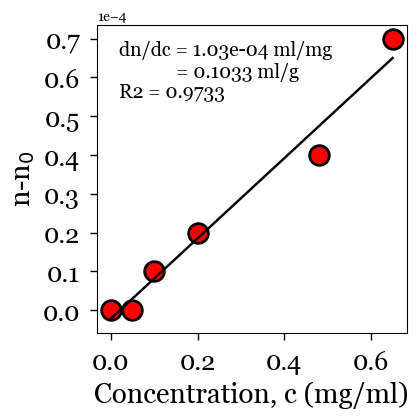

dn/dc = 1.03e-04 ml/mg = 0.1033 ml/g
R2 = 0.9733


In [33]:
PS_conc = PS_conc_values.values.flatten()
PS_dn = PS_dn_values.values.flatten()

def linear_equation(x, m, c):
    return m * x + c

p0_PS = [1.0, 0.0] 

popt_PS, pcov_PS = curve_fit(linear_equation, PS_conc, PS_dn, p0=p0_PS)

slope_PS, intercept_PS = popt_PS

y_pred_PS = linear_equation(PS_conc, slope_PS, intercept_PS)

r_squared_PS = r2_score(PS_dn, y_pred_PS)

c_PS = 'red'

fig, ax = plt.subplots(figsize=(4, 4))
PS_scatter = ax.scatter(PS_conc, PS_dn, s=200, alpha=1, marker='o', facecolors=c_PS, edgecolors='k', linewidths=2, clip_on=False)

x_PS = np.linspace(min(PS_conc), max(PS_conc), 100)
y_PS = slope_PS * x_PS + intercept_PS
ax.plot(x_PS, y_PS, color='k', linestyle='-')

plt.style.use('seaborn-notebook')
plt.rcParams['font.family'] = 'Georgia'
plt.xlabel('Concentration, c (mg/ml)', fontsize=20)
plt.ylabel('n-n$_0$', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.yaxis.set_major_formatter(formatter)

plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlim(1, 100)
#plt.ylim(-3, 0.5)
plt.text(0.02, 0.6e-4, f"dn/dc = {slope_PS:.2e} ml/mg \n            = {slope_PS*1000:.4f} ml/g", fontsize=14)
plt.text(0.02, 0.55e-4, f"R2 = {r_squared_PS:.4f}", fontsize=14)
#plt.savefig("PS in toluene dndc.png", dpi=1500, bbox_inches='tight')
plt.show()

print(f"dn/dc = {slope_PS:.2e} ml/mg = {slope_PS*1000:.4f} ml/g")
print(f"R2 = {r_squared_PS:.4f}")

### Zimm plot
Determination of the molecular weight

In [325]:
PS_Sol = '/Users/ningravi/Desktop/Python/RawData/20240506-selected/PS593.7k correcteddndc-Measurements.txt'